# Image Classification Training and Evaluation Notebook
### Spécialisé pour la reconnaissance de photos vs dessins, peintures, schémas et textes

## Imports

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import json
import datetime
import cv2
from pathlib import Path
import gc
import PIL

2025-04-10 10:20:04.793991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744273204.902994     751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744273204.936000     751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744273205.301253     751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744273205.301305     751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744273205.301308     751 computation_placer.cc:177] computation placer alr

In [5]:
# Configuration des paramètres
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

os.chdir('/mnt/c/Users/NyveK/Desktop/dev/deep learning/notebooks/livrable1')
print("Current directory:", os.getcwd())

# Chemins d'accès
PREPROCESSED_DATA_DIR = '/home/kevin/datasets/livrable1/processed'
MODEL_SAVE_DIR = 'models/5cv1'
LOG_DIR = 'logs/5cv1'

# Créer les dossiers nécessaires
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

Current directory: /mnt/c/Users/NyveK/Desktop/dev/deep learning/notebooks/livrable1


## Chargement et préparation des données

In [ ]:
def load_config_and_data(data_dir):
    """Charge la configuration et prépare les générateurs de données."""
    with open(os.path.join(data_dir, 'training_config.json'), 'r') as f:
        config = json.load(f)
    
    IMAGE_SIZE = config['image_size']
    BATCH_SIZE = config['batch_size']
    NUM_CLASSES = config['num_classes']
    CLASS_INDICES = config['classes']
    
    print(f"Configuration chargée: {IMAGE_SIZE}x{IMAGE_SIZE} pixels, {BATCH_SIZE} images par batch, {NUM_CLASSES} classes")
    
    # Créer les gdata generator
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = valid_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = valid_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return config, train_generator, val_generator, test_generator

# Charger les données
config, train_generator, val_generator, test_generator = load_config_and_data(PREPROCESSED_DATA_DIR)

IMAGE_SIZE = config['image_size']
BATCH_SIZE = config['batch_size']
NUM_CLASSES = len(train_generator.class_indices)
CLASSES = list(train_generator.class_indices.keys())

print(f"Classes: {CLASSES}")


Configuration chargée: 224x224 pixels, 32 images par batch, 5 classes
Found 28979 images belonging to 5 classes.
Found 6209 images belonging to 5 classes.
Found 6210 images belonging to 5 classes.
Classes: ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


## Implémentation des modèles


Nous avons sélectionner 3 implémentation dont 2 différentes représentant l'état de l'art dans l'exercice de classification d'images.
Une des implémentation est dit custom car nous avons essayer de réimplementer une d'elle en utilisant notre code source.
Ils sont tous 3 mis en compétition.

- EfficientNet : https://paperswithcode.com/method/efficientnet
- ResNet :    https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d
- Handmade Resnet

In [14]:
def create_custom_resnet(input_shape=(224, 224, 3), num_classes=5):
    """Implémentation personnalisée de ResNet optimisée pour la reconnaissance de photos."""
    
    def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, block_name=''):
        residual = x
        
        # Première convolution
        y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                         name=f'{block_name}_conv1')(x)
        y = layers.BatchNormalization(name=f'{block_name}_bn1')(y)
        y = layers.Activation('relu', name=f'{block_name}_relu1')(y)
        
        # Seconde convolution
        y = layers.Conv2D(filters, kernel_size, padding='same', 
                         name=f'{block_name}_conv2')(y)
        y = layers.BatchNormalization(name=f'{block_name}_bn2')(y)
        
        # Ajustement dimensionnel si nécessaire
        if downsample or stride != 1:
            residual = layers.Conv2D(filters, 1, strides=stride, padding='same', 
                                   name=f'{block_name}_shortcut')(residual)
            residual = layers.BatchNormalization(name=f'{block_name}_shortcut_bn')(residual)
        
        # Connexion résiduelle
        y = layers.Add(name=f'{block_name}_add')([y, residual])
        y = layers.Activation('relu', name=f'{block_name}_relu2')(y)
        
        return y
    
    # Entrée
    inputs = layers.Input(shape=input_shape, name='input')
    
    # Couche initiale avec filtres plus larges pour capturer des motifs globaux
    # utiles pour distinguer photos vs dessins/peintures
    x = layers.Conv2D(64, 7, strides=2, padding='same', name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)
    
    # Blocs résiduels
    # Premier groupe - 64 filtres
    x = residual_block(x, 64, block_name='block2_1')
    x = residual_block(x, 64, block_name='block2_2')
    x = residual_block(x, 64, block_name='block2_3')
    
    # Deuxième groupe - 128 filtres
    x = residual_block(x, 128, stride=2, downsample=True, block_name='block3_1')
    x = residual_block(x, 128, block_name='block3_2')
    x = residual_block(x, 128, block_name='block3_3')
    x = residual_block(x, 128, block_name='block3_4')
    
    # Troisième groupe - 256 filtres
    x = residual_block(x, 256, stride=2, downsample=True, block_name='block4_1')
    x = residual_block(x, 256, block_name='block4_2')
    x = residual_block(x, 256, block_name='block4_3')
    x = residual_block(x, 256, block_name='block4_4')
    
    # Quatrième groupe - 512 filtres
    x = residual_block(x, 512, stride=2, downsample=True, block_name='block5_1')
    x = residual_block(x, 512, block_name='block5_2')
    
    # Couche finale
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(0.5, name='dropout')(x)  # Dropout important pour la généralisation
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='custom_resnet')
    
    return model

def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=5, base_model_name='resnet50'):
    """Crée un modèle par transfer learning avec différentes architectures préentraînées."""
    
    # Sélection du modèle de base
    if base_model_name == 'resnet50':
        base_model = applications.ResNet50(weights='imagenet', 
                                         include_top=False, 
                                         input_shape=input_shape)
        preprocess_input = applications.resnet50.preprocess_input
    elif base_model_name == 'efficientnetb0':
        base_model = applications.EfficientNetB0(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=input_shape)
        preprocess_input = applications.efficientnet.preprocess_input
    elif base_model_name == 'xception':
        base_model = applications.Xception(weights='imagenet', 
                                         include_top=False, 
                                         input_shape=input_shape)
        preprocess_input = applications.xception.preprocess_input
    else:
        raise ValueError(f"Modèle de base non supporté: {base_model_name}")
    
    # Figer le modèle de base initialement
    base_model.trainable = False
    
    # Construire le modèle complet
    inputs = layers.Input(shape=input_shape, name='input')
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    
    # Couches de classification personnalisées
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.BatchNormalization()(x)
    
    # Couche dense intermédiaire avec dropout
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    # Couche de sortie
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=f'transfer_{base_model_name}')
    
    return model, base_model


## Configuration de l'entrainement

In [ ]:
def configure_training(model, learning_rate=0.001, model_name='photo_classifier'):
    """Configure les callbacks et l'optimiseur pour l'entraînement."""
    
    # Horodatage pour les fichiers de sauvegarde
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_{timestamp}.h5")
    
    # Callbacks
    callbacks = [
        # Callback : Sauvegarde du meilleur modèle
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        # Callback : Arrêt anticipé
        EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=10,
            verbose=1,
            restore_best_weights=True
        ),
        # Callback : Réduction du taux d'apprentissage sur plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Callback : TensorBoard pour visualisation
        TensorBoard(
            log_dir=os.path.join(LOG_DIR, f'{model_name}_{timestamp}')
        )
    ]
    
    # Optimiseur et compilation : On choisit Adam pour sa rapidité et son efficacité
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    return callbacks, model_path


## Entraînement et évaluation

In [ ]:
def train_model(model, train_generator, val_generator, callbacks, 
               epochs=50, fine_tune_at=0, base_model=None):
    """Entraîne le modèle avec fine-tuning optionnel pour le transfer learning."""
    
    print("\n==== Démarrage de l'entraînement ====")
    
    # Phase 1: Entraînement initial
    print("Phase 1: Entraînement des couches supérieures")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=epochs // 2 if fine_tune_at > 0 else epochs, # On raccourcit la phase 1 si fine-tuning
        callbacks=callbacks,
        verbose=1
    )
    
    # Phase 2: Fine-tuning (dans le cas du pas custom)
    if fine_tune_at > 0 and base_model is not None:
        print(f"\nPhase 2: Fine-tuning à partir de la couche {fine_tune_at}")
        
        # Dégeler une partie du modèle de base
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
            
        # Recompiler avec un taux d'apprentissage plus faible
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')]
        )
        
        # Second entraînement
        fine_tune_history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.samples // val_generator.batch_size,
            epochs=epochs // 2,
            initial_epoch=history.epoch[-1] + 1, # On reprend à la fin de la phase 1
            callbacks=callbacks,
            verbose=1
        )
        
        # Fusionner les historiques
        for key in fine_tune_history.history:
            history.history[key].extend(fine_tune_history.history[key])
    
    return history

def evaluate_model(model, test_generator, class_names):
    """Évalue le modèle sur le jeu de test et visualise les résultats."""
    print("\n==== Évaluation du modèle ====")
    
    # Évaluation des métriques
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
    
    print(f"Précision sur l'ensemble de test: {test_acc:.4f}")
    print(f"Perte sur l'ensemble de test: {test_loss:.4f}")
    print(f"Précision (métrique): {test_precision:.4f}")
    print(f"Rappel: {test_recall:.4f}")
    
    # Prédictions sur l'ensemble de test
    test_generator.reset()
    y_true = []
    y_pred = []
    
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        batch_pred = model.predict(x_batch)
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
        if i >= test_generator.samples // test_generator.batch_size - 1:
            break
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.title('Matrice de confusion')
    plt.show()
    
    # Rapport de classification
    print("\nRapport de classification:")
    cr = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(cr)
    
    return test_acc, cm, cr


## Visualisation et analyse des erreurs

In [17]:
def plot_training_history(history, model_name="Modèle"):
    """Visualise les courbes d'apprentissage."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Précision
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Précision')
    axes[0, 0].set_ylabel('Précision')
    axes[0, 0].set_xlabel('Époque')
    axes[0, 0].legend()
    
    # Perte
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Perte')
    axes[0, 1].set_ylabel('Perte')
    axes[0, 1].set_xlabel('Époque')
    axes[0, 1].legend()
    
    # Précision (métrique)
    axes[1, 0].plot(history.history['precision'], label='Train')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Précision (métrique)')
    axes[1, 0].set_ylabel('Précision')
    axes[1, 0].set_xlabel('Époque')
    axes[1, 0].legend()
    
    # Rappel
    axes[1, 1].plot(history.history['recall'], label='Train')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Rappel')
    axes[1, 1].set_ylabel('Rappel')
    axes[1, 1].set_xlabel('Époque')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.suptitle(f'Métriques d\'entraînement - {model_name}', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Afficher les meilleures performances
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    
    print(f"Meilleures performances ({model_name}):")
    print(f"Époque: {best_epoch+1}")
    print(f"Précision validation: {best_val_acc:.4f}")

def analyze_errors(model, test_generator, class_names):
    """Analyse et visualise des exemples d'erreurs de classification."""
    print("\n==== Analyse des erreurs de classification ====")
    
    # Collecter des exemples d'erreurs
    test_generator.reset()
    errors = []
    
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred = model.predict(x_batch)
        
        for j in range(len(x_batch)):
            true_class = np.argmax(y_batch[j])
            pred_class = np.argmax(y_pred[j])
            
            if true_class != pred_class:  # C'est une erreur
                confidence = y_pred[j][pred_class]
                errors.append({
                    'image': x_batch[j],
                    'true_class': true_class,
                    'pred_class': pred_class,
                    'confidence': confidence
                })
        
        if i >= test_generator.samples // test_generator.batch_size - 1:
            break
    
    # Afficher quelques erreurs (maximum 10)
    n_errors = min(10, len(errors))
    if n_errors > 0:
        fig, axes = plt.subplots(2, 5, figsize=(15, 6)) if n_errors > 5 else plt.subplots(1, n_errors, figsize=(15, 3))
        axes = axes.flatten() if n_errors > 5 else ([axes] if n_errors == 1 else axes)
        
        for i in range(n_errors):
            error = errors[i]
            axes[i].imshow(error['image'])
            axes[i].set_title(f"Vraie: {class_names[error['true_class']]}\n"
                             f"Prédite: {class_names[error['pred_class']]}\n"
                             f"Confiance: {error['confidence']:.2f}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Analyse des types d'erreurs les plus fréquents
        error_types = {}
        for error in errors:
            error_pair = (class_names[error['true_class']], class_names[error['pred_class']])
            if error_pair in error_types:
                error_types[error_pair] += 1
            else:
                error_types[error_pair] = 1
        
        print("Types d'erreurs les plus fréquents:")
        for (true, pred), count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {true} classifié comme {pred}: {count} occurrences")
    else:
        print("Aucune erreur trouvée dans l'ensemble de test!")


## Comparaison et ensemble de modèles


In [18]:
def compare_models(models, model_names, test_generator, class_names):
    """Compare les performances de plusieurs modèles."""
    print("\n==== Comparaison des modèles ====")
    
    results = []
    
    for model, name in zip(models, model_names):
        print(f"\nÉvaluation de {name}")
        test_acc, _, _ = evaluate_model(model, test_generator, class_names)
        results.append((name, test_acc))
    
    # Visualiser la comparaison
    plt.figure(figsize=(10, 6))
    names = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    
    plt.bar(names, accuracies)
    plt.title('Comparaison des modèles - Précision sur l\'ensemble de test')
    plt.ylabel('Précision')
    plt.ylim(0.5, 1.0)
    
    # Ajouter les valeurs sur les barres
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
    
    plt.show()
    
    return results

def ensemble_prediction(models, test_generator, class_names):
    """Combine les prédictions de plusieurs modèles pour améliorer la performance."""
    print("\n==== Prédiction par ensemble de modèles ====")
    
    test_generator.reset()
    y_true = []
    ensemble_preds = []
    
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_true.extend(np.argmax(y_batch, axis=1))
        
        # Moyenne des probabilités de tous les modèles
        avg_preds = np.zeros((x_batch.shape[0], NUM_CLASSES))
        
        for model in models:
            preds = model.predict(x_batch)
            avg_preds += preds
        
        avg_preds /= len(models)
        ensemble_preds.extend(np.argmax(avg_preds, axis=1))
        
        if i >= test_generator.samples // test_generator.batch_size - 1:
            break
    
    # Évaluer l'ensemble
    ensemble_acc = np.mean(np.array(y_true) == np.array(ensemble_preds))
    print(f"Précision de l'ensemble: {ensemble_acc:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, ensemble_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.title('Matrice de confusion - Ensemble de modèles')
    plt.show()
    
    return ensemble_acc


## Exécution de l'expérimentation complète



===== Entraînement de ResNet50 =====

==== Démarrage de l'entraînement ====
Phase 1: Entraînement des couches supérieures
Epoch 1/15


/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9027 - auc: 0.9813 - loss: 0.3418 - precision: 0.9077 - recall: 0.8997
Epoch 1: val_accuracy improved from -inf to 0.96698, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - accuracy: 0.9027 - auc: 0.9813 - loss: 0.3416 - precision: 0.9077 - recall: 0.8998 - val_accuracy: 0.9670 - val_auc: 0.9968 - val_loss: 0.1001 - val_precision: 0.9679 - val_recall: 0.9667 - learning_rate: 0.0010
Epoch 2/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.9062 - auc: 0.9919 - loss: 0.2665 - precision: 0.9062 - recall: 0.9062

/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.96698 to 0.96714, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9062 - auc: 0.9919 - loss: 0.2665 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.9671 - val_auc: 0.9968 - val_loss: 0.1000 - val_precision: 0.9684 - val_recall: 0.9668 - learning_rate: 0.0010
Epoch 3/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9580 - auc: 0.9961 - loss: 0.1270 - precision: 0.9596 - recall: 0.9569
Epoch 3: val_accuracy improved from 0.96714 to 0.97278, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.9580 - auc: 0.9961 - loss: 0.1270 - precision: 0.9596 - recall: 0.9569 - val_accuracy: 0.9728 - val_auc: 0.9977 - val_loss: 0.0821 - val_precision: 0.9740 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 4/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0332 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_accuracy improved from 0.97278 to 0.97294, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0332 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9729 - val_auc: 0.9977 - val_loss: 0.0833 - val_precision: 0.9745 - val_recall: 0.9726 - learning_rate: 0.0010
Epoch 5/15
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9668 - auc: 0.9971 - loss: 0.1022 - precision: 0.9682 - recall: 0.9651
Epoch 5: val_accuracy did not improve from 0.97294
905/905 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.9668 - auc: 0.9971 - loss: 0.1022 - precision: 0.9682 - recall: 0.9651 - val_accuracy: 0.9715 - val_auc: 0.9978 - val_loss: 0.0865 - val_precision: 0.9718 - val_recall: 0.9715 - learning_rate: 0.0010
Epoch 6/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0405 - precision: 1.0000 - recall: 1.0000
Epoch 6: val_accuracy did not improve from 0.97294
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0405 - precision: 1.0000 

905/905 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.9765 - auc: 0.9989 - loss: 0.0629 - precision: 0.9776 - recall: 0.9754 - val_accuracy: 0.9784 - val_auc: 0.9979 - val_loss: 0.0708 - val_precision: 0.9793 - val_recall: 0.9774 - learning_rate: 2.0000e-04
Epoch 10/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0237 - precision: 1.0000 - recall: 1.0000
Epoch 10: val_accuracy did not improve from 0.97841
905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0237 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9784 - val_auc: 0.9978 - val_loss: 0.0708 - val_precision: 0.9793 - val_recall: 0.9774 - learning_rate: 2.0000e-04
Epoch 11/15
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9844 - auc: 0.9994 - loss: 0.0455 - precision: 0.9853 - recall: 0.9833
Epoch 11: val_accuracy improved from 0.97841 to 0.97922, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.9844 - auc: 0.9994 - loss: 0.0455 - precision: 0.9853 - recall: 0.9833 - val_accuracy: 0.9792 - val_auc: 0.9974 - val_loss: 0.0728 - val_precision: 0.9794 - val_recall: 0.9784 - learning_rate: 2.0000e-04
Epoch 12/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.9688 - auc: 0.9988 - loss: 0.1322 - precision: 0.9688 - recall: 0.9688
Epoch 12: val_accuracy improved from 0.97922 to 0.97938, saving model to models/5cv1/photo_classifier_resnet50_20250409-105951.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9688 - auc: 0.9988 - loss: 0.1322 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9794 - val_auc: 0.9974 - val_loss: 0.0727 - val_precision: 0.9795 - val_recall: 0.9786 - learning_rate: 2.0000e-04
Epoch 13/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9844 - auc: 0.9994 - loss: 0.0437 - precision: 0.9851 - recall: 0.9833
Epoch 13: val_accuracy did not improve from 0.97938
905/905 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.9844 - auc: 0.9994 - loss: 0.0437 - precision: 0.9851 - recall: 0.9833 - val_accuracy: 0.9774 - val_auc: 0.9973 - val_loss: 0.0727 - val_precision: 0.9781 - val_recall: 0.9771 - learning_rate: 2.0000e-04
Epoch 14/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.9688 - auc: 0.9984 - loss: 0.1474 - precision: 0.9688 - recall: 0.9688
Epoch 14: val_accuracy did not improve from 0.97938

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
905/905 ━━━━━━━━━━

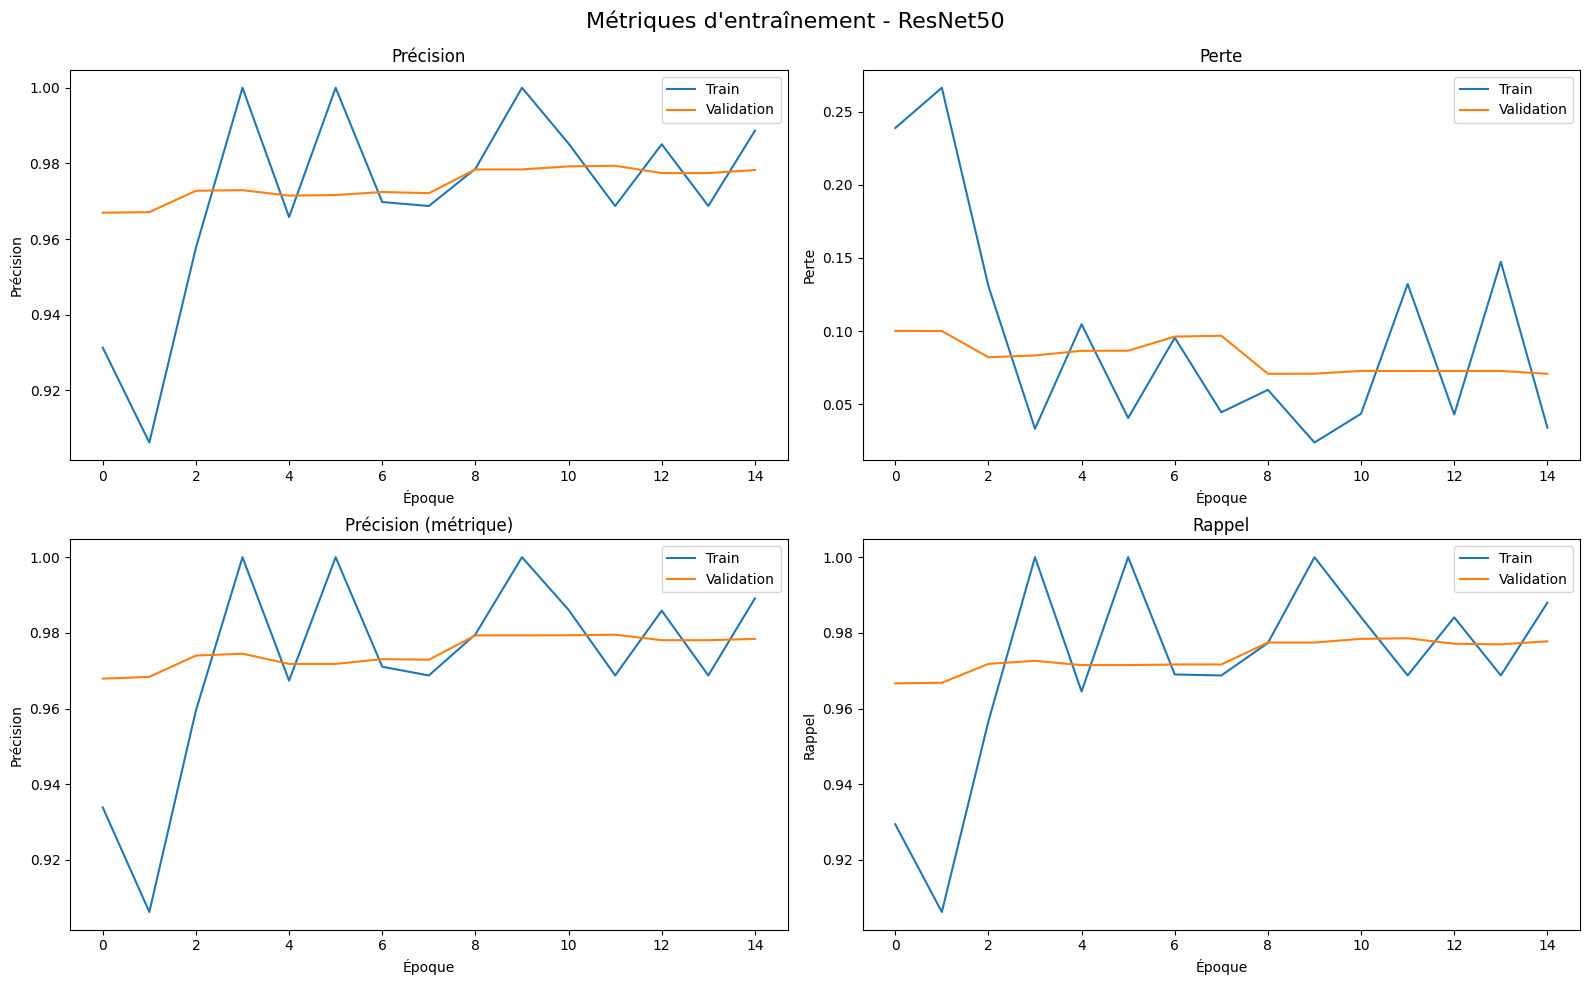

Meilleures performances (ResNet50):
Époque: 12
Précision validation: 0.9794

==== Évaluation du modèle ====
195/195 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9785 - auc: 0.9972 - loss: 0.0830 - precision: 0.9796 - recall: 0.9784
Précision sur l'ensemble de test: 0.9839
Perte sur l'ensemble de test: 0.0570
Précision (métrique): 0.9844
Rappel: 0.9837
AUC: 0.9982
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

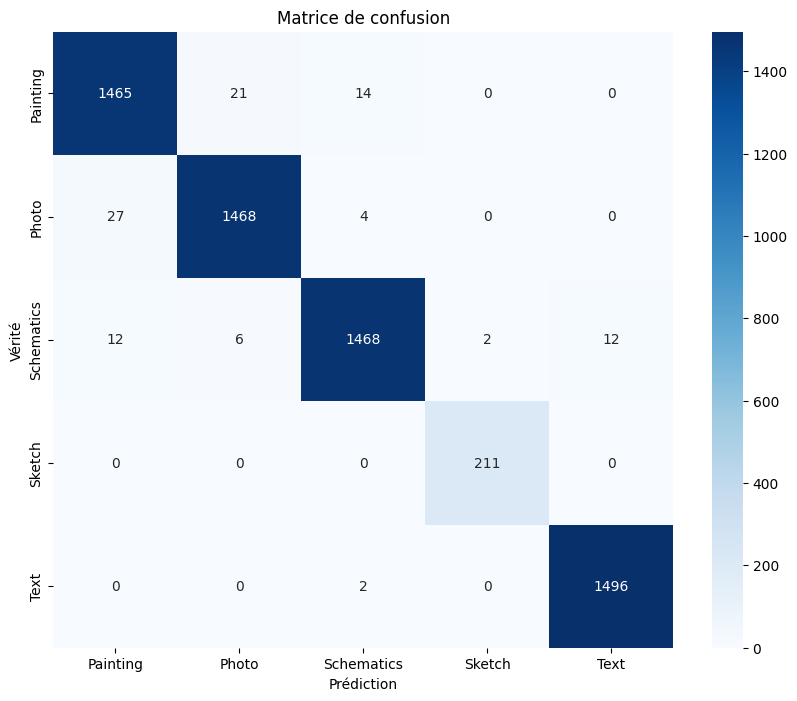


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.9741    0.9767    0.9754      1500
       Photo     0.9819    0.9793    0.9806      1499
  Schematics     0.9866    0.9787    0.9826      1500
      Sketch     0.9906    1.0000    0.9953       211
        Text     0.9920    0.9987    0.9953      1498

    accuracy                         0.9839      6208
   macro avg     0.9850    0.9867    0.9858      6208
weighted avg     0.9839    0.9839    0.9839      6208


==== Analyse des erreurs de classification ====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━

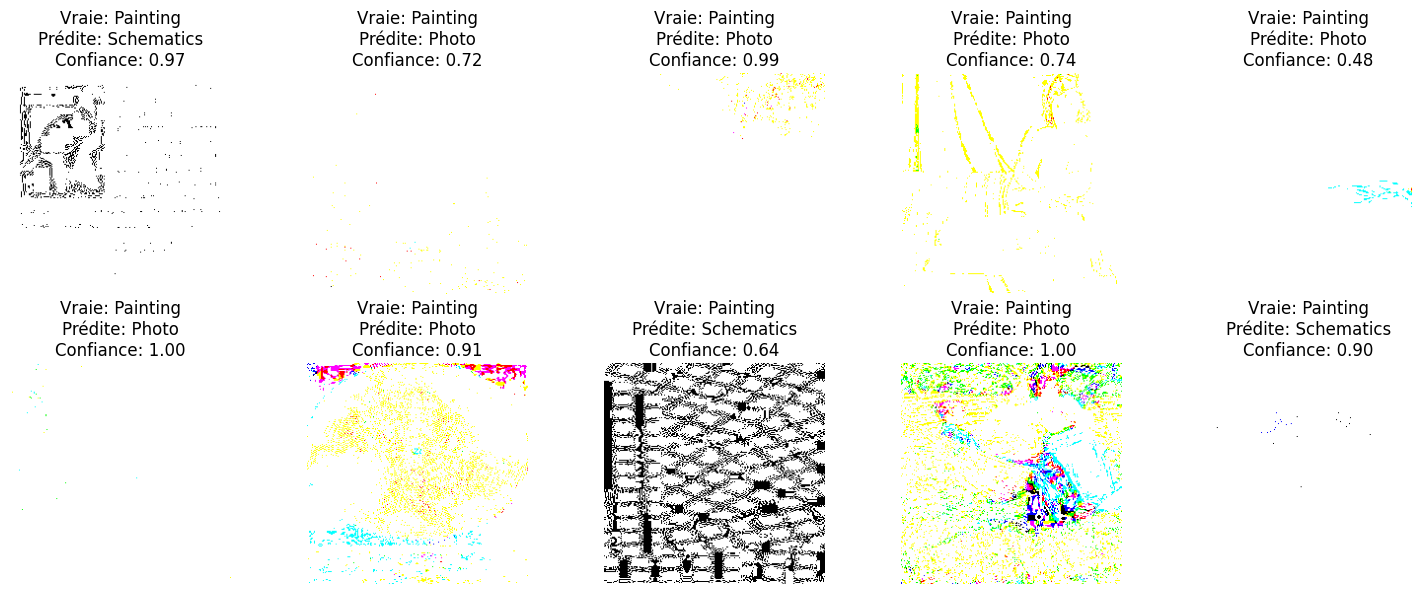

Types d'erreurs les plus fréquents:
  Photo classifié comme Painting: 27 occurrences
  Painting classifié comme Photo: 21 occurrences
  Painting classifié comme Schematics: 14 occurrences
  Schematics classifié comme Painting: 12 occurrences
  Schematics classifié comme Text: 12 occurrences

===== Entraînement de EfficientNetB0 =====
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

==== Démarrage de l'entraînement ====
Phase 1: Entraînement des couches supérieures
Epoch 1/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8959 - auc: 0.9815 - loss: 0.3331 - precision: 0.9044 - recall: 0.8902
Epoch 1: val_accuracy improved from -inf to 0.97149, saving model to models/5cv1/photo_classifier_efficientnetb0_20250409-110811.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 69s 52ms/step - accuracy: 0.8959 - auc: 0.9815 - loss: 0.3330 - precision: 0.9044 - recall: 0.8903 - val_accuracy: 0.9715 - val_auc: 0.9967 - val_loss: 0.0999 - val_precision: 0.9726 - val_recall: 0.9707 - learning_rate: 0.0010
Epoch 2/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0261 - precision: 1.0000 - recall: 1.0000

/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.97149
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0261 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9712 - val_auc: 0.9967 - val_loss: 0.0991 - val_precision: 0.9724 - val_recall: 0.9702 - learning_rate: 0.0010
Epoch 3/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9567 - auc: 0.9959 - loss: 0.1308 - precision: 0.9588 - recall: 0.9552
Epoch 3: val_accuracy improved from 0.97149 to 0.97374, saving model to models/5cv1/photo_classifier_efficientnetb0_20250409-110811.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.9567 - auc: 0.9959 - loss: 0.1308 - precision: 0.9588 - recall: 0.9552 - val_accuracy: 0.9737 - val_auc: 0.9981 - val_loss: 0.0814 - val_precision: 0.9742 - val_recall: 0.9729 - learning_rate: 0.0010
Epoch 4/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9688 - auc: 0.9998 - loss: 0.0625 - precision: 0.9688 - recall: 0.9688
Epoch 4: val_accuracy improved from 0.97374 to 0.97487, saving model to models/5cv1/photo_classifier_efficientnetb0_20250409-110811.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9688 - auc: 0.9998 - loss: 0.0625 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9749 - val_auc: 0.9981 - val_loss: 0.0806 - val_precision: 0.9752 - val_recall: 0.9739 - learning_rate: 0.0010
Epoch 5/15
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9635 - auc: 0.9970 - loss: 0.1096 - precision: 0.9652 - recall: 0.9617
Epoch 5: val_accuracy improved from 0.97487 to 0.97552, saving model to models/5cv1/photo_classifier_efficientnetb0_20250409-110811.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.9635 - auc: 0.9970 - loss: 0.1096 - precision: 0.9652 - recall: 0.9617 - val_accuracy: 0.9755 - val_auc: 0.9978 - val_loss: 0.0757 - val_precision: 0.9761 - val_recall: 0.9747 - learning_rate: 0.0010
Epoch 6/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0514 - precision: 1.0000 - recall: 1.0000
Epoch 6: val_accuracy did not improve from 0.97552
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0514 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9750 - val_auc: 0.9978 - val_loss: 0.0761 - val_precision: 0.9756 - val_recall: 0.9741 - learning_rate: 0.0010
Epoch 7/15
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9720 - auc: 0.9982 - loss: 0.0862 - precision: 0.9733 - recall: 0.9702
Epoch 7: val_accuracy improved from 0.97552 to 0.97906, saving model to models/5cv1/photo_classifier_efficientnetb0_20250409-110811.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.9720 - auc: 0.9982 - loss: 0.0862 - precision: 0.9733 - recall: 0.9702 - val_accuracy: 0.9791 - val_auc: 0.9979 - val_loss: 0.0736 - val_precision: 0.9795 - val_recall: 0.9791 - learning_rate: 0.0010
Epoch 8/15
  1/905 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9375 - auc: 0.9990 - loss: 0.0638 - precision: 0.9375 - recall: 0.9375
Epoch 8: val_accuracy did not improve from 0.97906
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9375 - auc: 0.9990 - loss: 0.0638 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.9787 - val_auc: 0.9979 - val_loss: 0.0737 - val_precision: 0.9792 - val_recall: 0.9786 - learning_rate: 0.0010
Epoch 9/15
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9700 - auc: 0.9976 - loss: 0.0932 - precision: 0.9712 - recall: 0.9684
Epoch 9: val_accuracy did not improve from 0.97906
905/905 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.9700 - auc: 0.9976 - loss: 0.0932 - precision: 0.971

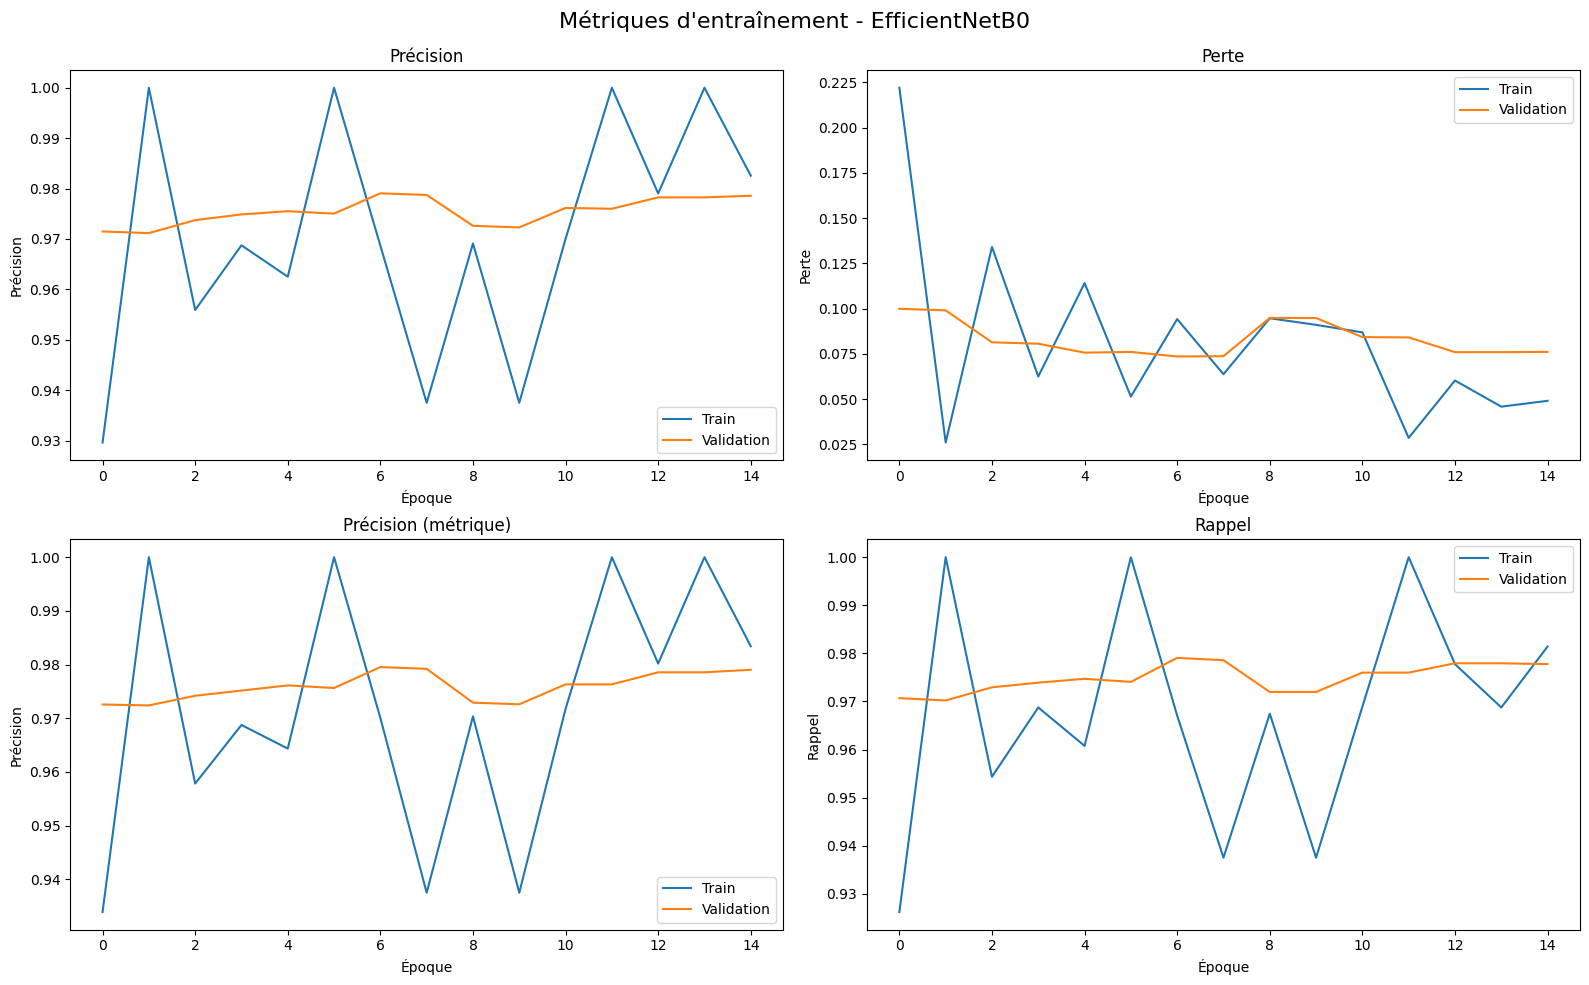

Meilleures performances (EfficientNetB0):
Époque: 7
Précision validation: 0.9791

==== Évaluation du modèle ====
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9655 - auc: 0.9961 - loss: 0.1155 - precision: 0.9660 - recall: 0.9650
Précision sur l'ensemble de test: 0.9770
Perte sur l'ensemble de test: 0.0774
Précision (métrique): 0.9776
Rappel: 0.9767
AUC: 0.9978
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━

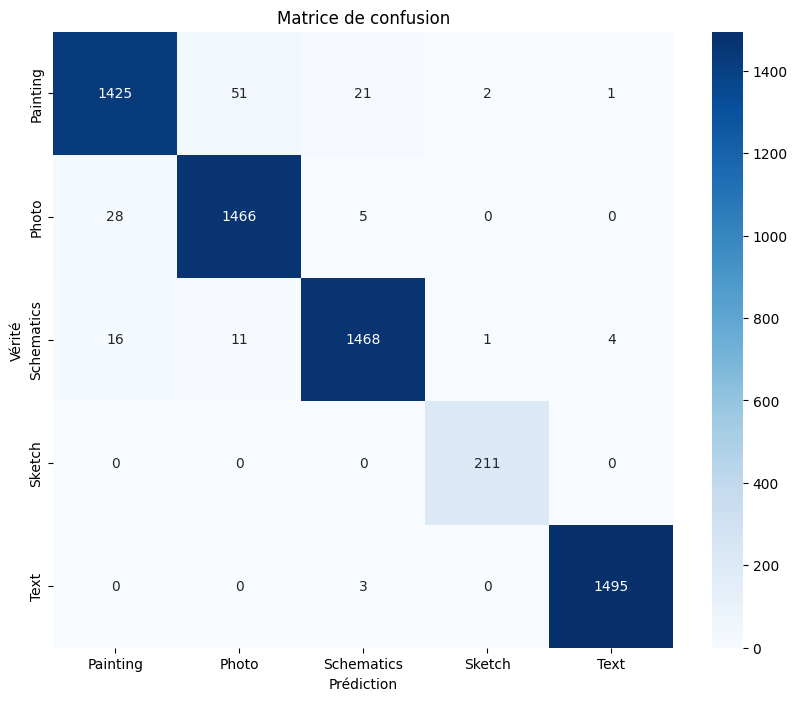


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.9700    0.9500    0.9599      1500
       Photo     0.9594    0.9780    0.9686      1499
  Schematics     0.9806    0.9787    0.9796      1500
      Sketch     0.9860    1.0000    0.9929       211
        Text     0.9967    0.9980    0.9973      1498

    accuracy                         0.9770      6208
   macro avg     0.9785    0.9809    0.9797      6208
weighted avg     0.9770    0.9770    0.9769      6208


===== Entraînement de ResNet personnalisé =====

==== Démarrage de l'entraînement ====
Phase 1: Entraînement des couches supérieures
Epoch 1/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5821 - auc: 0.8785 - loss: 0.9957 - precision: 0.6486 - recall: 0.4635

2025-04-09 11:16:16.293232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_804', 20 bytes spill stores, 20 bytes spill loads

2025-04-09 11:16:16.338218: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_804', 4 bytes spill stores, 4 bytes spill loads

2025-04-09 11:16:16.404344: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_804', 180 bytes spill stores, 180 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.55912, saving model to models/5cv1/photo_classifier_custom_20250409-111416.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 133s 115ms/step - accuracy: 0.5822 - auc: 0.8786 - loss: 0.9955 - precision: 0.6486 - recall: 0.4636 - val_accuracy: 0.5591 - val_auc: 0.8658 - val_loss: 1.0532 - val_precision: 0.6027 - val_recall: 0.4570 - learning_rate: 0.0010
Epoch 2/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 2:01 134ms/step - accuracy: 0.6250 - auc: 0.8895 - loss: 0.9631 - precision: 0.6400 - recall: 0.5000

/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.55912
905/905 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6250 - auc: 0.8895 - loss: 0.9631 - precision: 0.6400 - recall: 0.5000 - val_accuracy: 0.5391 - val_auc: 0.8508 - val_loss: 1.1474 - val_precision: 0.5818 - val_recall: 0.4486 - learning_rate: 0.0010
Epoch 3/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7259 - auc: 0.9487 - loss: 0.6123 - precision: 0.7681 - recall: 0.6645
Epoch 3: val_accuracy did not improve from 0.55912
905/905 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.7260 - auc: 0.9487 - loss: 0.6122 - precision: 0.7681 - recall: 0.6646 - val_accuracy: 0.4708 - val_auc: 0.7167 - val_loss: 46.7209 - val_precision: 0.4731 - val_recall: 0.4441 - learning_rate: 0.0010
Epoch 4/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:24 93ms/step - accuracy: 0.8125 - auc: 0.9819 - loss: 0.4064 - precision: 0.8519 - recall: 0.7188
Epoch 4: val_accuracy did not improve from 0.55912
905/905 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.

905/905 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.8280 - auc: 0.9764 - loss: 0.4147 - precision: 0.8479 - recall: 0.8080 - val_accuracy: 0.8241 - val_auc: 0.9766 - val_loss: 0.4081 - val_precision: 0.8394 - val_recall: 0.8075 - learning_rate: 2.0000e-04
Epoch 8/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:20 89ms/step - accuracy: 0.7812 - auc: 0.9767 - loss: 0.4073 - precision: 0.7812 - recall: 0.7812
Epoch 8: val_accuracy did not improve from 0.82410
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7812 - auc: 0.9767 - loss: 0.4073 - precision: 0.7812 - recall: 0.7812 - val_accuracy: 0.8231 - val_auc: 0.9767 - val_loss: 0.4073 - val_precision: 0.8400 - val_recall: 0.8067 - learning_rate: 2.0000e-04
Epoch 9/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8507 - auc: 0.9809 - loss: 0.3699 - precision: 0.8639 - recall: 0.8340
Epoch 9: val_accuracy did not improve from 0.82410
905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 87ms/step - accuracy: 0.8507 - auc: 0.9809 - loss: 0.3699 - precisi

905/905 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.8645 - auc: 0.9840 - loss: 0.3415 - precision: 0.8771 - recall: 0.8518 - val_accuracy: 0.8795 - val_auc: 0.9868 - val_loss: 0.3029 - val_precision: 0.8871 - val_recall: 0.8718 - learning_rate: 2.0000e-04
Epoch 12/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:19 87ms/step - accuracy: 0.9062 - auc: 0.9850 - loss: 0.3050 - precision: 0.9062 - recall: 0.9062
Epoch 12: val_accuracy did not improve from 0.87951
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9062 - auc: 0.9850 - loss: 0.3050 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.8782 - val_auc: 0.9869 - val_loss: 0.3028 - val_precision: 0.8865 - val_recall: 0.8692 - learning_rate: 2.0000e-04
Epoch 13/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8762 - auc: 0.9859 - loss: 0.3176 - precision: 0.8874 - recall: 0.8658
Epoch 13: val_accuracy did not improve from 0.87951
905/905 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.8762 - auc: 0.9859 - loss: 0.3176 - pre

905/905 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.8939 - auc: 0.9892 - loss: 0.2739 - precision: 0.9015 - recall: 0.8873 - val_accuracy: 0.8800 - val_auc: 0.9869 - val_loss: 0.3011 - val_precision: 0.8865 - val_recall: 0.8719 - learning_rate: 2.0000e-04
Epoch 18/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:18 87ms/step - accuracy: 0.8125 - auc: 0.9719 - loss: 0.4635 - precision: 0.8387 - recall: 0.8125
Epoch 18: val_accuracy did not improve from 0.87999
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8125 - auc: 0.9719 - loss: 0.4635 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.8758 - val_auc: 0.9865 - val_loss: 0.3072 - val_precision: 0.8846 - val_recall: 0.8679 - learning_rate: 2.0000e-04
Epoch 19/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8938 - auc: 0.9896 - loss: 0.2702 - precision: 0.9029 - recall: 0.8850
Epoch 19: val_accuracy did not improve from 0.87999
905/905 ━━━━━━━━━━━━━━━━━━━━ 77s 85ms/step - accuracy: 0.8938 - auc: 0.9896 - loss: 0.2702 - pre

905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 87ms/step - accuracy: 0.9022 - auc: 0.9903 - loss: 0.2600 - precision: 0.9083 - recall: 0.8949 - val_accuracy: 0.8930 - val_auc: 0.9882 - val_loss: 0.2818 - val_precision: 0.8986 - val_recall: 0.8876 - learning_rate: 2.0000e-04
Epoch 22/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:20 89ms/step - accuracy: 0.9688 - auc: 0.9932 - loss: 0.2109 - precision: 0.9688 - recall: 0.9688
Epoch 22: val_accuracy did not improve from 0.89304
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9688 - auc: 0.9932 - loss: 0.2109 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.8895 - val_auc: 0.9874 - val_loss: 0.2898 - val_precision: 0.8950 - val_recall: 0.8840 - learning_rate: 2.0000e-04
Epoch 23/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9084 - auc: 0.9918 - loss: 0.2361 - precision: 0.9149 - recall: 0.9022
Epoch 23: val_accuracy improved from 0.89304 to 0.89900, saving model to models/5cv1/photo_classifier_custom_20250409-111416.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.9084 - auc: 0.9918 - loss: 0.2361 - precision: 0.9149 - recall: 0.9022 - val_accuracy: 0.8990 - val_auc: 0.9897 - val_loss: 0.2639 - val_precision: 0.9044 - val_recall: 0.8948 - learning_rate: 2.0000e-04
Epoch 24/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:19 88ms/step - accuracy: 0.8125 - auc: 0.9844 - loss: 0.3629 - precision: 0.8387 - recall: 0.8125
Epoch 24: val_accuracy did not improve from 0.89900
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8125 - auc: 0.9844 - loss: 0.3629 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.8980 - val_auc: 0.9893 - val_loss: 0.2656 - val_precision: 0.9020 - val_recall: 0.8938 - learning_rate: 2.0000e-04
Epoch 25/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9173 - auc: 0.9931 - loss: 0.2174 - precision: 0.9224 - recall: 0.9117
Epoch 25: val_accuracy did not improve from 0.89900
905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 87ms/step - accuracy: 0.9173 - auc: 0.9931 - loss: 0.2174 - pre

905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.9218 - auc: 0.9933 - loss: 0.2073 - precision: 0.9259 - recall: 0.9162 - val_accuracy: 0.9195 - val_auc: 0.9921 - val_loss: 0.2217 - val_precision: 0.9242 - val_recall: 0.9138 - learning_rate: 2.0000e-04
Epoch 28/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:19 88ms/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0739 - precision: 0.9688 - recall: 0.9688
Epoch 28: val_accuracy did not improve from 0.91946
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0739 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9183 - val_auc: 0.9918 - val_loss: 0.2254 - val_precision: 0.9234 - val_recall: 0.9124 - learning_rate: 2.0000e-04
Epoch 29/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9281 - auc: 0.9940 - loss: 0.1955 - precision: 0.9328 - recall: 0.9230
Epoch 29: val_accuracy did not improve from 0.91946
905/905 ━━━━━━━━━━━━━━━━━━━━ 77s 85ms/step - accuracy: 0.9281 - auc: 0.9940 - loss: 0.1955 - pre

905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.9500 - auc: 0.9971 - loss: 0.1349 - precision: 0.9536 - recall: 0.9471 - val_accuracy: 0.9320 - val_auc: 0.9919 - val_loss: 0.2125 - val_precision: 0.9334 - val_recall: 0.9304 - learning_rate: 4.0000e-05
Epoch 34/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 1:17 86ms/step - accuracy: 0.9688 - auc: 0.9998 - loss: 0.0358 - precision: 0.9688 - recall: 0.9688
Epoch 34: val_accuracy improved from 0.93202 to 0.93235, saving model to models/5cv1/photo_classifier_custom_20250409-111416.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9688 - auc: 0.9998 - loss: 0.0358 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9323 - val_auc: 0.9918 - val_loss: 0.2124 - val_precision: 0.9345 - val_recall: 0.9306 - learning_rate: 4.0000e-05
Epoch 35/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9611 - auc: 0.9982 - loss: 0.1008 - precision: 0.9630 - recall: 0.9593
Epoch 35: val_accuracy did not improve from 0.93235
905/905 ━━━━━━━━━━━━━━━━━━━━ 79s 87ms/step - accuracy: 0.9611 - auc: 0.9982 - loss: 0.1008 - precision: 0.9630 - recall: 0.9593 - val_accuracy: 0.9277 - val_auc: 0.9915 - val_loss: 0.2221 - val_precision: 0.9298 - val_recall: 0.9259 - learning_rate: 4.0000e-05
Epoch 36/50
  1/905 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0736 - precision: 0.9688 - recall: 0.9688
Epoch 36: val_accuracy did not improve from 0.93235
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0736 - precis

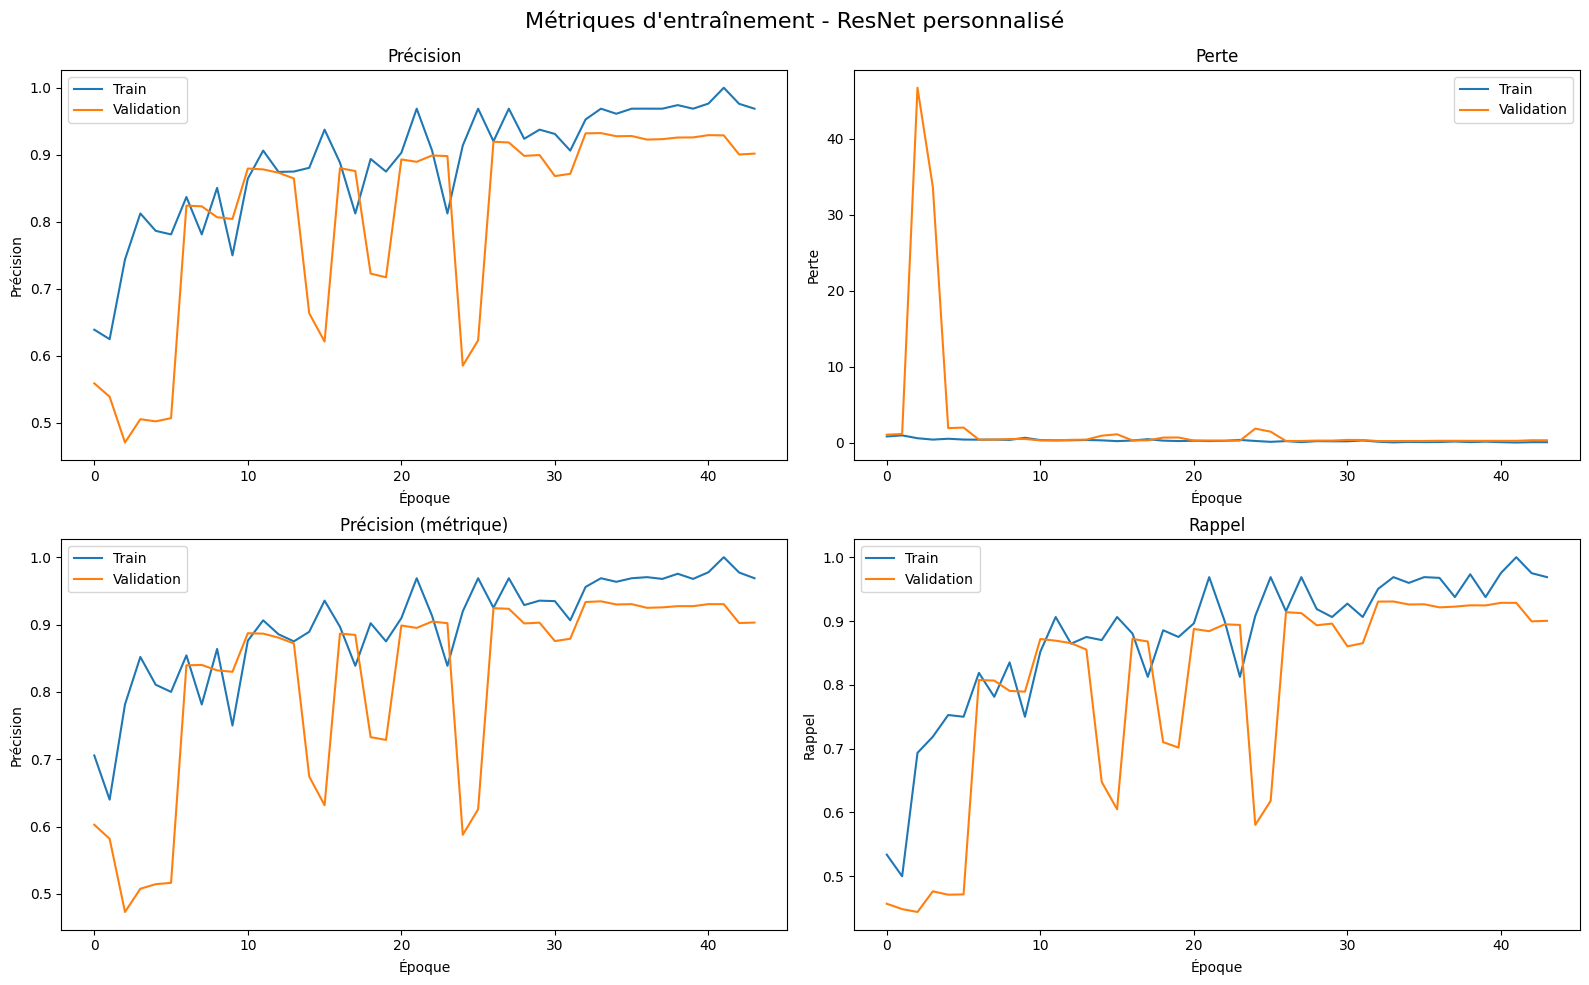

Meilleures performances (ResNet personnalisé):
Époque: 34
Précision validation: 0.9323

==== Évaluation du modèle ====
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8938 - auc: 0.9859 - loss: 0.3181 - precision: 0.8964 - recall: 0.8916

2025-04-09 11:46:04.996332: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_804', 72 bytes spill stores, 72 bytes spill loads



195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8941 - auc: 0.9859 - loss: 0.3172 - precision: 0.8967 - recall: 0.8919
Précision sur l'ensemble de test: 0.9225
Perte sur l'ensemble de test: 0.2327
Précision (métrique): 0.9249
Rappel: 0.9208
AUC: 0.9918
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━

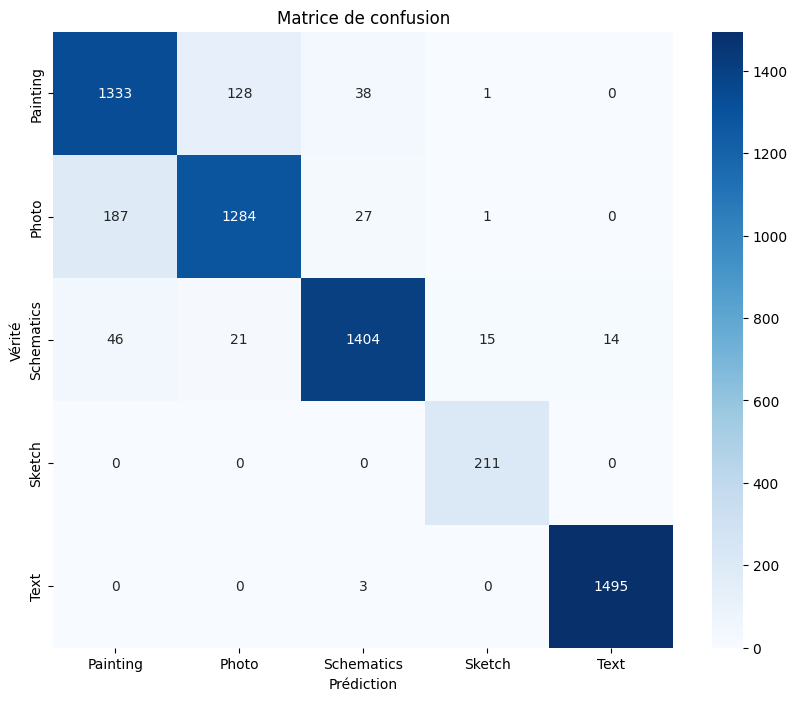


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.8512    0.8887    0.8695      1500
       Photo     0.8960    0.8566    0.8759      1499
  Schematics     0.9538    0.9360    0.9448      1500
      Sketch     0.9254    1.0000    0.9613       211
        Text     0.9907    0.9980    0.9943      1498

    accuracy                         0.9225      6208
   macro avg     0.9234    0.9358    0.9292      6208
weighted avg     0.9230    0.9225    0.9225      6208


==== Comparaison des modèles ====

Évaluation de ResNet50

==== Évaluation du modèle ====
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9785 - auc: 0.9972 - loss: 0.0830 - precision: 0.9796 - recall: 0.9784
Précision sur l'ensemble de test: 0.9839
Perte sur l'ensemble de test: 0.0570
Précision (métrique): 0.9844
Rappel: 0.9837
AUC: 0.9982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━

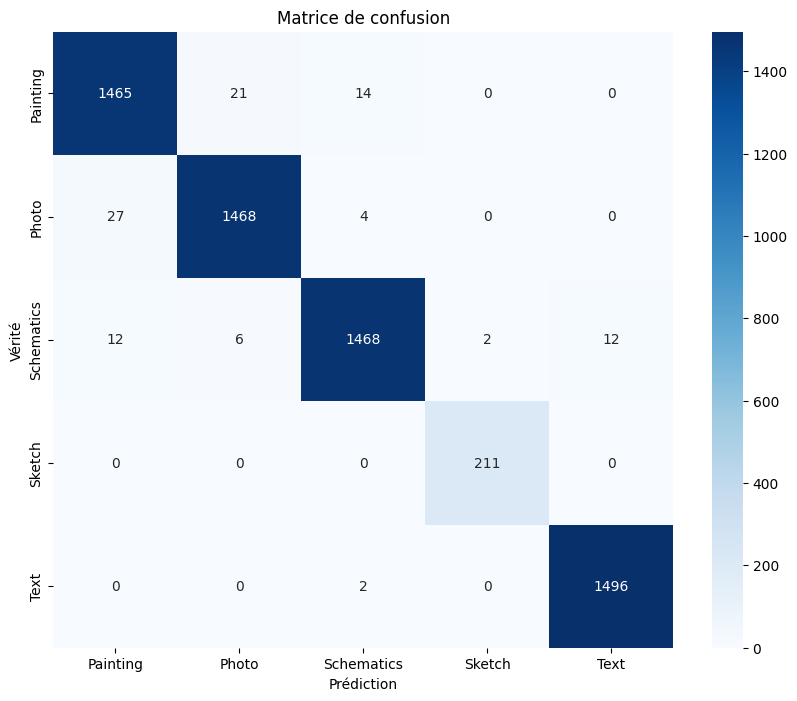


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.9741    0.9767    0.9754      1500
       Photo     0.9819    0.9793    0.9806      1499
  Schematics     0.9866    0.9787    0.9826      1500
      Sketch     0.9906    1.0000    0.9953       211
        Text     0.9920    0.9987    0.9953      1498

    accuracy                         0.9839      6208
   macro avg     0.9850    0.9867    0.9858      6208
weighted avg     0.9839    0.9839    0.9839      6208


Évaluation de EfficientNetB0

==== Évaluation du modèle ====
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9655 - auc: 0.9961 - loss: 0.1155 - precision: 0.9660 - recall: 0.9650
Précision sur l'ensemble de test: 0.9770
Perte sur l'ensemble de test: 0.0774
Précision (métrique): 0.9776
Rappel: 0.9767
AUC: 0.9978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━

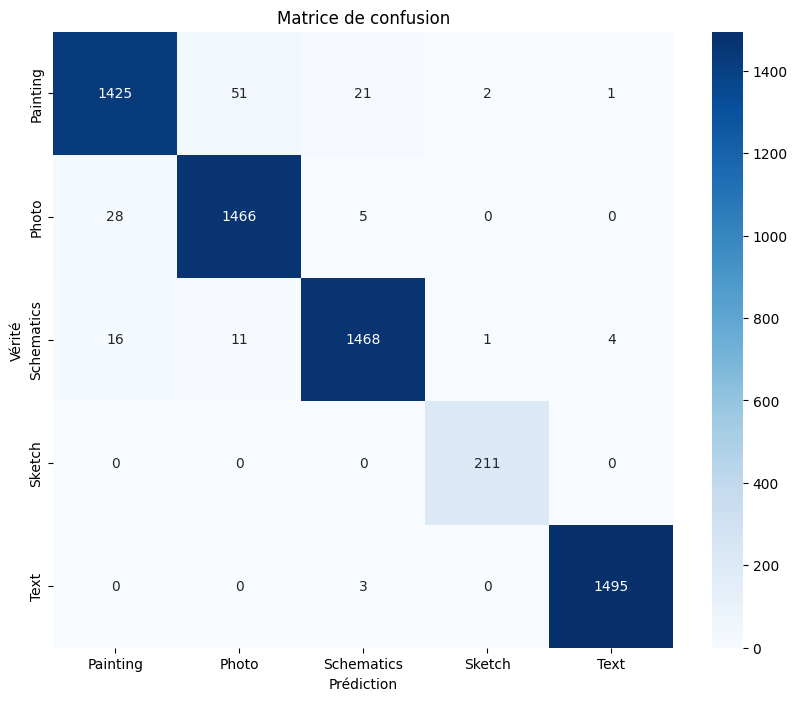


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.9700    0.9500    0.9599      1500
       Photo     0.9594    0.9780    0.9686      1499
  Schematics     0.9806    0.9787    0.9796      1500
      Sketch     0.9860    1.0000    0.9929       211
        Text     0.9967    0.9980    0.9973      1498

    accuracy                         0.9770      6208
   macro avg     0.9785    0.9809    0.9797      6208
weighted avg     0.9770    0.9770    0.9769      6208


Évaluation de ResNet personnalisé

==== Évaluation du modèle ====
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8941 - auc: 0.9859 - loss: 0.3172 - precision: 0.8967 - recall: 0.8919
Précision sur l'ensemble de test: 0.9225
Perte sur l'ensemble de test: 0.2327
Précision (métrique): 0.9249
Rappel: 0.9208
AUC: 0.9918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1

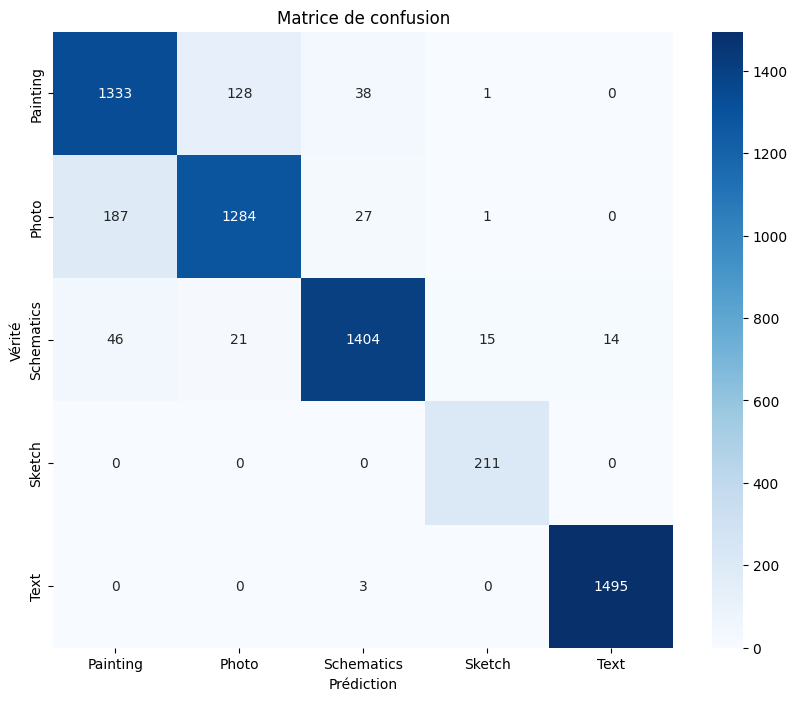


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.8512    0.8887    0.8695      1500
       Photo     0.8960    0.8566    0.8759      1499
  Schematics     0.9538    0.9360    0.9448      1500
      Sketch     0.9254    1.0000    0.9613       211
        Text     0.9907    0.9980    0.9943      1498

    accuracy                         0.9225      6208
   macro avg     0.9234    0.9358    0.9292      6208
weighted avg     0.9230    0.9225    0.9225      6208



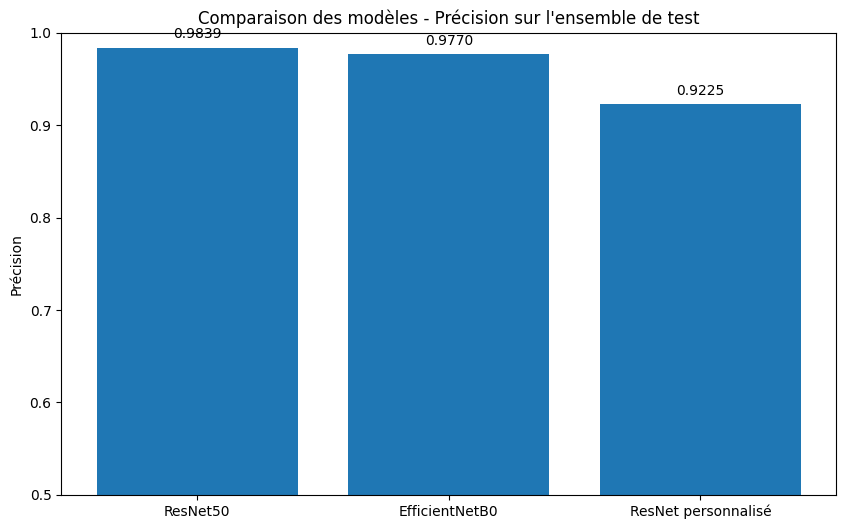


==== Prédiction par ensemble de modèles ====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 

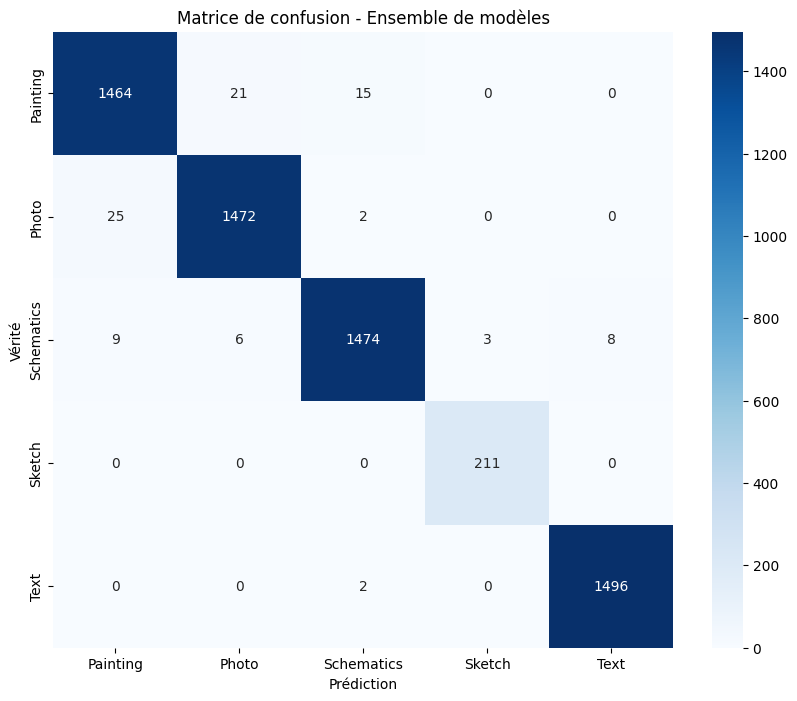


===== Conclusions =====
ResNet50: 0.9839
EfficientNetB0: 0.9770
ResNet personnalisé: 0.9225
Ensemble: 0.9853

Le meilleur modèle individuel est ResNet50 avec une précision de 0.9839
L'ensemble de modèles améliore la performance de 0.14%


In [ ]:
def run_experiment():
    """Exécute l'expérimentation complète avec plusieurs modèles."""
    models = []
    model_names = []
    histories = []
    
    # 1. Modèle ResNet50 par transfer learning (état de l'art pour cette tâche)
    print("\n===== Entraînement de ResNet50 =====")
    resnet_model, resnet_base = create_transfer_learning_model(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        num_classes=NUM_CLASSES,
        base_model_name='resnet50'
    )
    
    callbacks, _ = configure_training(resnet_model, model_name='photo_classifier_resnet50')
    
    # Entraînement bi-phases (avec fine-tuning)
    resnet_history = train_model(
        resnet_model,
        train_generator,
        val_generator,
        callbacks,
        epochs=30,
        fine_tune_at=100,  # Dégeler environ le dernier bloc de ResNet50
        base_model=resnet_base
    )
    
    plot_training_history(resnet_history, model_name='ResNet50')
    resnet_acc, _, _ = evaluate_model(resnet_model, test_generator, CLASSES)
    analyze_errors(resnet_model, test_generator, CLASSES)
    
    models.append(resnet_model)
    model_names.append('ResNet50')
    histories.append(resnet_history)
    
    # Libérer la mémoire avec le GAGARBAGE COLLECTOR :)
    gc.collect()
    tf.keras.backend.clear_session()
    
    # 2. EfficientNetB0 (alternative légère et performante)
    print("\n===== Entraînement de EfficientNetB0 =====")
    effnet_model, effnet_base = create_transfer_learning_model(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        num_classes=NUM_CLASSES,
        base_model_name='efficientnetb0'
    )
    
    callbacks, _ = configure_training(effnet_model, model_name='photo_classifier_efficientnetb0')
    
    effnet_history = train_model(
        effnet_model,
        train_generator,
        val_generator,
        callbacks,
        epochs=30,
        fine_tune_at=150,  # Dégeler environ le dernier bloc
        base_model=effnet_base
    )
    
    plot_training_history(effnet_history, model_name='EfficientNetB0')
    effnet_acc, _, _ = evaluate_model(effnet_model, test_generator, CLASSES)
    
    models.append(effnet_model)
    model_names.append('EfficientNetB0')
    histories.append(effnet_history)
    
    # Libérer la mémoire
    gc.collect()
    tf.keras.backend.clear_session()
    
    # 3. ResNet personnalisé
    print("\n===== Entraînement de ResNet personnalisé =====")
    custom_model = create_custom_resnet(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        num_classes=NUM_CLASSES
    )
    
    callbacks, _ = configure_training(custom_model, model_name='photo_classifier_custom')
    
    custom_history = train_model(
        custom_model,
        train_generator,
        val_generator,
        callbacks,
        epochs=50  # Plus d'époques pour le modèle entraîné from scratch
    )
    
    plot_training_history(custom_history, model_name='ResNet personnalisé')
    custom_acc, _, _ = evaluate_model(custom_model, test_generator, CLASSES)
    
    models.append(custom_model)
    model_names.append('ResNet personnalisé')
    histories.append(custom_history)
    
    # Comparer tous les modèles
    comparison_results = compare_models(models, model_names, test_generator, CLASSES)
    
    # Créer un ensemble des meilleurs modèles
    ensemble_acc = ensemble_prediction(models, test_generator, CLASSES)
    
    # Afficher les conclusions
    print("\n===== Conclusions =====")
    print(f"ResNet50: {resnet_acc:.4f}")
    print(f"EfficientNetB0: {effnet_acc:.4f}")
    print(f"ResNet personnalisé: {custom_acc:.4f}")
    print(f"Ensemble: {ensemble_acc:.4f}")
    
    # Identifier le meilleur modèle
    best_model_idx = np.argmax([resnet_acc, effnet_acc, custom_acc])
    best_model_name = ['ResNet50', 'EfficientNetB0', 'ResNet personnalisé'][best_model_idx]
    best_model_acc = [resnet_acc, effnet_acc, custom_acc][best_model_idx]
    
    print(f"\nLe meilleur modèle individuel est {best_model_name} avec une précision de {best_model_acc:.4f}")
    if ensemble_acc > best_model_acc:
        print(f"L'ensemble de modèles améliore la performance de {(ensemble_acc - best_model_acc) * 100:.2f}%")
    else:
        print(f"L'ensemble n'améliore pas la performance du meilleur modèle individuel")
    
    return models, histories, comparison_results, ensemble_acc

# Exécuter l'expérimentation
models, histories, comparison_results, ensemble_acc = run_experiment()


## Implémentation d'un modèle final pour production


===== Préparation du modèle final pour production =====
Found 28979 images belonging to 5 classes.
Phase 1: Entraînement des couches supérieures
Epoch 1/10
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9024 - loss: 0.3575 - precision: 0.9087 - recall: 0.8987
Epoch 1: accuracy improved from -inf to 0.93143, saving model to models/5cv1/photo_classifier_production_20250409-120924.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.9025 - loss: 0.3574 - precision: 0.9087 - recall: 0.8987 - learning_rate: 0.0010
Epoch 2/10
  1/905 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9688 - loss: 0.0948 - precision: 0.9688 - recall: 0.9688
Epoch 2: accuracy improved from 0.93143 to 0.96875, saving model to models/5cv1/photo_classifier_production_20250409-120924.h5


905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.0948 - precision: 0.9688 - recall: 0.9688 - learning_rate: 0.0010
Epoch 3/10
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9592 - loss: 0.1279 - precision: 0.9610 - recall: 0.9581
Epoch 3: accuracy did not improve from 0.96875
905/905 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.9592 - loss: 0.1279 - precision: 0.9610 - recall: 0.9581 - learning_rate: 0.0010
Epoch 4/10
  1/905 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9062 - loss: 0.1954 - precision: 0.9062 - recall: 0.9062
Epoch 4: accuracy did not improve from 0.96875
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.9062 - loss: 0.1954 - precision: 0.9062 - recall: 0.9062 - learning_rate: 0.0010
Epoch 5/10
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9668 - loss: 0.1039 - precision: 0.9679 - recall: 0.9660
Epoch 5: accuracy did not improve from 0.96875
905/905 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.9668 - loss: 0.103

905/905 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 1.0000 - loss: 0.0435 - precision: 1.0000 - recall: 1.0000 - learning_rate: 0.0010
Epoch 7/10
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9699 - loss: 0.0946 - precision: 0.9708 - recall: 0.9687
Epoch 7: accuracy did not improve from 1.00000
905/905 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.9699 - loss: 0.0946 - precision: 0.9708 - recall: 0.9687 - learning_rate: 0.0010
Epoch 8/10
  1/905 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9688 - loss: 0.0776 - precision: 0.9677 - recall: 0.9375
Epoch 8: accuracy did not improve from 1.00000
905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.9688 - loss: 0.0776 - precision: 0.9677 - recall: 0.9375 - learning_rate: 0.0010
Epoch 9/10
904/905 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9731 - loss: 0.0827 - precision: 0.9740 - recall: 0.9720
Epoch 9: accuracy did not improve from 1.00000
905/905 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.9731 - loss: 0.0

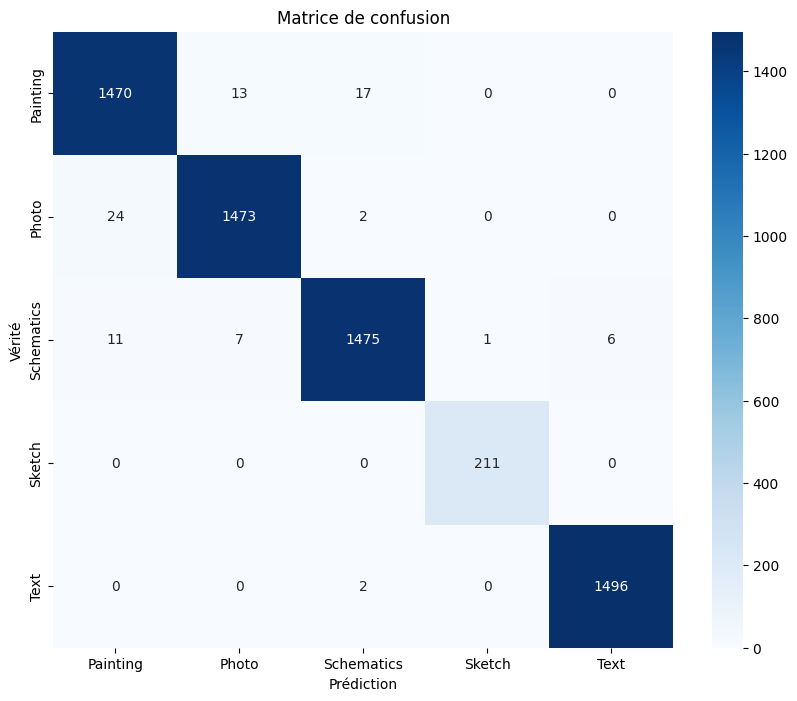


Rapport de classification:
              precision    recall  f1-score   support

    Painting     0.9767    0.9800    0.9784      1500
       Photo     0.9866    0.9827    0.9846      1499
  Schematics     0.9860    0.9833    0.9846      1500
      Sketch     0.9953    1.0000    0.9976       211
        Text     0.9960    0.9987    0.9973      1498

    accuracy                         0.9866      6208
   macro avg     0.9881    0.9889    0.9885      6208
weighted avg     0.9866    0.9866    0.9866      6208


Optimisation du modèle pour le déploiement...
INFO:tensorflow:Assets written to: /tmp/tmp7d8kc28o/assets


INFO:tensorflow:Assets written to: /tmp/tmp7d8kc28o/assets


Saved artifact at '/tmp/tmp7d8kc28o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139747557381456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139748627267664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561260240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561260624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561260816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561259280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561259472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561264848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561265424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561265616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139747561264

W0000 00:00:1744194123.068579   10424 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744194123.070301   10424 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-09 12:22:03.114096: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7d8kc28o
2025-04-09 12:22:03.126881: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-09 12:22:03.126907: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7d8kc28o
I0000 00:00:1744194123.266450   10424 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-09 12:22:03.286211: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-09 12:22:04.473752: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp7d8kc28o
2025-04-09 12:22:04.639287: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

Modèle final sauvegardé en format TFLite: models/5cv1/photo_classifier_production_20250409-120924.tflite
Précision sur l'ensemble de test: 0.9866


In [23]:
def create_production_model():
    """Crée et entraîne le modèle final optimisé pour la production."""
    print("\n===== Préparation du modèle final pour production =====")
    
    # Utiliser ResNet50 qui est généralement le plus performant pour cette tâche
    model, base_model = create_transfer_learning_model(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        num_classes=NUM_CLASSES,
        base_model_name='resnet50'
    )
    
    # Configuration spécifique pour la production
    # Utiliser tout le dataset (train+val) pour l'entraînement final
    train_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    train_val_generator = train_val_datagen.flow_from_directory(
        os.path.join(PREPROCESSED_DATA_DIR, 'train'),  # Utiliser seulement train pour simplifier
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    # Callbacks optimisés pour la production
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    final_model_path = os.path.join(MODEL_SAVE_DIR, f"photo_classifier_production_{timestamp}.h5")
    
    callbacks = [
        ModelCheckpoint(
            filepath=final_model_path,
            monitor='accuracy',  # Surveiller accuracy puisqu'on n'a pas de validation
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            mode='min',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Compiler le modèle
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    # Phase 1: Entraînement des couches supérieures
    print("Phase 1: Entraînement des couches supérieures")
    model.fit(
        train_val_generator,
        steps_per_epoch=train_val_generator.samples // train_val_generator.batch_size,
        epochs=10,  # Moins d'époques car on va faire du fine-tuning
        callbacks=callbacks,
        verbose=1
    )
    
    # Phase 2: Fine-tuning
    print("Phase 2: Fine-tuning")
    base_model.trainable = True
    
    # Figer les premiers blocs
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Recompiler avec un taux d'apprentissage plus faible
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    model.fit(
        train_val_generator,
        steps_per_epoch=train_val_generator.samples // train_val_generator.batch_size,
        epochs=20,
        callbacks=callbacks,
        verbose=1
    )
    
    # Évaluer sur l'ensemble de test
    test_acc, cm, cr = evaluate_model(model, test_generator, CLASSES)
    
    # Convertir et optimiser pour le déploiement
    print("\nOptimisation du modèle pour le déploiement...")
    tf_lite_model_path = os.path.join(MODEL_SAVE_DIR, f"photo_classifier_production_{timestamp}.tflite")
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open(tf_lite_model_path, 'wb') as f:
        f.write(tflite_model)
    
    print(f"Modèle final sauvegardé en format TFLite: {tf_lite_model_path}")
    print(f"Précision sur l'ensemble de test: {test_acc:.4f}")
    
    return model, final_model_path, tf_lite_model_path

# Créer le modèle final pour production
production_model, model_path, tflite_path = create_production_model()


## Fonctions de prédiction avec meilleur modèle de production


In [63]:
def predict_image_type(model, image_path, class_names, is_tflite=True, preprocess_input=None, show_visualization=True):
    """
    Prédit le type d'une image avec prétraitement adapté automatiquement au modèle.
    
    Args:
        model: Le modèle de prédiction (TF ou TFLite) ou chemin vers le modèle
        image_path: Chemin vers l'image à prédire
        class_names: Liste des noms de classes
        is_tflite: Indique si le modèle est au format TFLite
        preprocess_input: Fonction de prétraitement à utiliser (détection auto si None)
        show_visualization: Afficher les visualisations des prédictions
    
    Returns:
        tuple: (classe prédite, probabilités par classe, confiance)
    """
    # Vérifier que le fichier existe
    if not os.path.exists(image_path):
        print(f"Erreur: Le fichier {image_path} n'existe pas.")
        return None, None, 0
    
    # Détection du modèle et de son prétraitement si non spécifié
    if preprocess_input is None:
        if is_tflite:
            # Pour TFLite, essayer de déterminer le modèle à partir du nom du fichier
            if isinstance(model, str):
                model_name = os.path.basename(model).lower()
                if 'resnet' in model_name:
                    print("Modèle détecté: ResNet - Utilisation du prétraitement ResNet")
                    preprocess_input = tf.keras.applications.resnet50.preprocess_input
                elif 'efficient' in model_name:
                    print("Modèle détecté: EfficientNet - Utilisation du prétraitement EfficientNet")
                    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
                elif 'xception' in model_name:
                    print("Modèle détecté: Xception - Utilisation du prétraitement Xception")
                    preprocess_input = tf.keras.applications.xception.preprocess_input
                else:
                    print("Type de modèle non détecté, utilisation du prétraitement standard (division par 255)")
                    preprocess_input = lambda x: x / 255.0
            else:
                # Si on ne peut pas déterminer, utiliser le prétraitement ResNet (le meilleur modèle selon les résultats)
                print("Utilisation du prétraitement ResNet par défaut")
                preprocess_input = tf.keras.applications.resnet50.preprocess_input
        else:
            # Pour les modèles TensorFlow, on peut essayer de détecter le type de modèle
            if hasattr(model, 'name'):
                model_name = model.name.lower()
                if 'resnet' in model_name:
                    preprocess_input = tf.keras.applications.resnet50.preprocess_input
                elif 'efficient' in model_name:
                    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
                elif 'xception' in model_name:
                    preprocess_input = tf.keras.applications.xception.preprocess_input
                else:
                    preprocess_input = lambda x: x / 255.0
            else:
                # Utiliser ResNet comme fallback
                preprocess_input = tf.keras.applications.resnet50.preprocess_input
    
    # Charger l'image avec différentes méthodes pour garantir la robustesse
    try:
        # Méthode 1: Utiliser keras.preprocessing
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
    except Exception as e:
        print(f"Erreur avec tf.keras.preprocessing: {e}")
        try:
            # Méthode 2: Utiliser OpenCV
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        except Exception as e:
            print(f"Erreur avec OpenCV: {e}")
            return None, None, 0
    
    # Garder une copie de l'image originale pour l'affichage
    display_img = img if isinstance(img, PIL.Image.Image) else img_array.astype(np.uint8)
    
    # Appliquer le prétraitement
    processed_img_array = preprocess_input(img_array.copy())
    
    # Ajouter la dimension du batch
    processed_img_array = np.expand_dims(processed_img_array, axis=0)
    
    # Faire la prédiction en fonction du type de modèle
    if is_tflite:
        try:
            interpreter = tf.lite.Interpreter(model_path=model if isinstance(model, str) else None, 
                                            model_content=model if not isinstance(model, str) else None)
            interpreter.allocate_tensors()
            
            # Obtenir les détails des tenseurs d'entrée et de sortie
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            
            # Définir les données d'entrée
            interpreter.set_tensor(input_details[0]['index'], processed_img_array.astype(np.float32))
            
            # Exécuter l'inférence
            interpreter.invoke()
            
            # Obtenir les résultats
            predictions = interpreter.get_tensor(output_details[0]['index'])[0]
            
        except Exception as e:
            print(f"Erreur lors de l'inférence TFLite: {e}")
            # Imprimez également la trace d'erreur complète pour déboguer
            import traceback
            traceback.print_exc()
            return None, None, 0
    
    # Classe prédite
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    
    # Afficher les résultats si demandé
    if show_visualization:
        # Afficher l'image et la prédiction
        plt.figure(figsize=(8, 8))
        if isinstance(display_img, PIL.Image.Image):
            plt.imshow(display_img)
        else:
            plt.imshow(display_img)
        
        plt.title(f"Prédiction: {class_names[predicted_class]}\nConfiance: {confidence:.4f}", fontsize=16)
        plt.axis('off')
        plt.show()
        
        # Afficher les probabilités pour chaque classe avec un code couleur
        plt.figure(figsize=(12, 5))
        colors = ['#3498db' if i != predicted_class else '#e74c3c' for i in range(len(class_names))]
        bars = plt.bar(class_names, predictions, color=colors)
        plt.title('Probabilités par classe', fontsize=16)
        plt.ylabel('Probabilité')
        plt.ylim(0, 1.1)  # Légèrement plus grand pour les annotations
        plt.xticks(rotation=45, ha='right')
        
        # Ajouter les valeurs sur les barres
        for i, prob in enumerate(predictions):
            plt.text(i, prob + 0.02, f'{prob:.4f}', ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Afficher les diagnostics d'erreur potentielle si la confiance est faible
        if confidence < 0.8:
            print(f"⚠️ Confiance faible ({confidence:.4f}) - Interprétation potentiellement incorrecte")
            
            # Analyser les caractéristiques de l'image qui pourraient expliquer l'erreur
            try:
                # Vérifier si l'image est en niveaux de gris
                if len(img_array.shape) < 3 or img_array.shape[2] == 1 or np.allclose(img_array[:,:,0], img_array[:,:,1], atol=5):
                    print("  - L'image semble être en niveaux de gris, ce qui peut affecter la classification")
                
                # Vérifier la variance de l'image (trop faible = image unie)
                if np.var(img_array) < 1000:
                    print("  - L'image a peu de contraste/variation, ce qui peut rendre la détection difficile")
                
                # Vérifier la qualité
                if np.mean(img_array) < 20 or np.mean(img_array) > 235:
                    print("  - L'image semble être trop sombre ou trop claire")
            except:
                pass
    
    return class_names[predicted_class], predictions, confidence

def predict_all_images_in_folder(model, folder_path, class_names, is_tflite=True, preprocess_input=None, limit=None):
    """
    Prédit le type de toutes les images dans un dossier avec analyse détaillée.
    
    Args:
        model: Le modèle de prédiction ou son chemin
        folder_path: Chemin vers le dossier contenant les images
        class_names: Liste des noms de classes
        is_tflite: Indique si le modèle est au format TFLite
        preprocess_input: Fonction de prétraitement optionnelle
        limit: Nombre maximum d'images à traiter (None = toutes)
    
    Returns:
        dict: Résultats de la prédiction avec statistiques
    """
    # Formats d'image supportés
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp']
    
    # Récupérer tous les fichiers image du dossier
    image_files = []
    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(os.path.join(folder_path, file))
    
    if not image_files:
        print(f"Aucune image trouvée dans le dossier {folder_path}")
        return {}
    
    # Limiter le nombre d'images à traiter si demandé
    if limit and limit < len(image_files):
        print(f"Limitation à {limit} images sur {len(image_files)} disponibles")
        image_files = image_files[:limit]
    else:
        print(f"Traitement de {len(image_files)} images...")
    
    # Résultats pour chaque image
    results = {}
    confidences = []
    
    # Prédire chaque image avec une barre de progression
    for i, img_path in enumerate(tqdm(image_files, desc="Prédiction des images")):
        print(f"\n[{i+1}/{len(image_files)}] Analyse de {os.path.basename(img_path)}:")
        predicted_class, probs, confidence = predict_image_type(
            model, img_path, class_names, is_tflite, preprocess_input
        )
        if predicted_class is not None:
            results[os.path.basename(img_path)] = {
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_probs': probs
            }
            confidences.append(confidence)
    
    # Afficher un résumé avec des statistiques
    print("\n" + "="*60)
    print("               RÉSUMÉ DES PRÉDICTIONS                  ")
    print("="*60)
    
    # Statistiques des prédictions par classe
    class_counts = {cls: 0 for cls in class_names}
    for result in results.values():
        class_counts[result['predicted_class']] += 1

    print("\n=== DISTRIBUTION DES PRÉDICTIONS ===")
    # Vérification pour éviter la division par zéro
    if len(results) > 0:  # CORRECTION ICI
        for cls, count in class_counts.items():
            print(f"{cls}: {count} images ({count/len(results)*100:.1f}%)")
    else:
        print("Aucune prédiction n'a réussi. Vérifiez les erreurs ci-dessus.")
    
    # Statistiques de confiance
    if confidences:
        conf_avg = np.mean(confidences)
        conf_std = np.std(confidences)
        conf_min = np.min(confidences)
        conf_max = np.max(confidences)
        
        print("\n=== STATISTIQUES DE CONFIANCE ===")
        print(f"Moyenne: {conf_avg:.4f}")
        print(f"Écart-type: {conf_std:.4f}")
        print(f"Minimum: {conf_min:.4f}")
        print(f"Maximum: {conf_max:.4f}")
        
        # Images avec confiance faible
        low_confidence = [(img, info['confidence'], info['predicted_class']) 
                         for img, info in results.items() if info['confidence'] < 0.8]
        
        if low_confidence:
            print("\n=== IMAGES AVEC CONFIANCE FAIBLE (<0.8) ===")
            for img, conf, cls in sorted(low_confidence, key=lambda x: x[1]):
                print(f"{img}: {cls} (confiance: {conf:.4f})")
    
    # Ajouter les statistiques aux résultats
    summary = {
        'class_distribution': class_counts,
        'confidence_stats': {
            'mean': conf_avg if confidences else 0,
            'std': conf_std if confidences else 0,
            'min': conf_min if confidences else 0,
            'max': conf_max if confidences else 0
        },
        'total_images': len(results)
    }
    
    return {'predictions': results, 'summary': summary}

def load_and_configure_model(model_path=None, model_dir='models/5cv1', force_reload=False):
    """
    Charge le modèle le plus récent et configure automatiquement le prétraitement approprié.
    
    Args:
        model_path: Chemin spécifique vers un modèle (prioritaire si spécifié)
        model_dir: Répertoire où chercher les modèles
        force_reload: Si True, force le rechargement même si un modèle est déjà chargé
        
    Returns:
        tuple: (chemin du modèle, fonction de prétraitement, est_tflite)
    """
    # Si un chemin spécifique est fourni, l'utiliser
    if model_path:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Le modèle spécifié n'existe pas: {model_path}")
        final_model_path = model_path
    else:
        # Sinon chercher le plus récent
        if hasattr(load_and_configure_model, 'cached_model_path') and not force_reload:
            print(f"Utilisation du modèle en cache: {load_and_configure_model.cached_model_path}")
            final_model_path = load_and_configure_model.cached_model_path
        else:
            # Chercher tous les fichiers de modèle dans le répertoire
            model_files = []
            for ext in ['.tflite', '.h5', '.keras']:
                model_files.extend([f for f in os.listdir(model_dir) if f.endswith(ext)])
            
            if not model_files:
                raise FileNotFoundError(f"Aucun modèle trouvé dans {model_dir}")
            
            # Extraire les timestamps des noms de fichiers
            # Format attendu: photo_classifier_production_YYYYMMDD-HHMMSS.ext
            timestamps = []
            for file in model_files:
                try:
                    # Extraire le timestamp de la partie finale du nom de fichier
                    timestamp_str = file.split('_')[-1].split('.')[0]
                    # Convertir en objet datetime pour pouvoir comparer
                    timestamp = datetime.datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
                    timestamps.append((file, timestamp))
                except (ValueError, IndexError):
                    print(f"Format de nom de fichier non reconnu pour {file}, ignoré.")
            
            # Trier par timestamp (du plus récent au plus ancien)
            timestamps.sort(key=lambda x: x[1], reverse=True)
            
            if not timestamps:
                raise ValueError("Aucun modèle avec un format de timestamp valide n'a été trouvé.")
            
            # Prendre le plus récent
            latest_model_file = timestamps[0][0]
            final_model_path = os.path.join(model_dir, latest_model_file)
            
            # Stocker en cache
            load_and_configure_model.cached_model_path = final_model_path
    
    # Déterminer s'il s'agit d'un modèle TFLite
    is_tflite = final_model_path.endswith('.tflite')
    
    # Déterminer la fonction de prétraitement appropriée
    model_name = os.path.basename(final_model_path).lower()
    if 'resnet' in model_name:
        print(f"Modèle détecté: ResNet - Configuration du prétraitement ResNet")
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    elif 'efficient' in model_name:
        print(f"Modèle détecté: EfficientNet - Configuration du prétraitement EfficientNet")
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    elif 'xception' in model_name:
        print(f"Modèle détecté: Xception - Configuration du prétraitement Xception")
        preprocess_input = tf.keras.applications.xception.preprocess_input
    else:
        print(f"Type de modèle non identifié à partir du nom - Utilisation du prétraitement ResNet (meilleur modèle)")
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    
    print(f"Modèle chargé: {final_model_path}")
    print(f"Format: {'TFLite' if is_tflite else 'Keras'}")
    if 'timestamp' in locals():
        print(f"Date de création: {timestamps[0][1].strftime('%Y-%m-%d %H:%M:%S')}")
    
    return final_model_path, preprocess_input, is_tflite

def predict_with_best_model(image_path=None, folder_path=None, model_path=None, 
                           model_dir='models/5cv1', class_names=None):
    """
    Fonction principale qui prédit avec le meilleur modèle disponible,
    en configurant automatiquement tous les paramètres nécessaires.
    
    Args:
        image_path: Chemin vers une image spécifique à prédire
        folder_path: Chemin vers un dossier d'images à prédire
        model_path: Chemin spécifique vers un modèle à utiliser
        model_dir: Répertoire où chercher le modèle le plus récent
        class_names: Noms des classes (détecté automatiquement si None)
    
    Returns:
        Résultats de la prédiction
    """
    # Vérifier qu'au moins une source d'image est spécifiée
    if not image_path and not folder_path:
        raise ValueError("Vous devez spécifier au moins image_path ou folder_path")
    
    # Charger les noms de classes si non spécifiés
    if class_names is None:
        # Classes par défaut pour notre problème
        class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
        print(f"Utilisation des classes par défaut: {class_names}")
    
    # Charger et configurer le modèle
    model_path, preprocess_input, is_tflite = load_and_configure_model(
        model_path=model_path, 
        model_dir=model_dir
    )
    
    # Prédire une seule image ou un dossier
    if image_path:
        # Prédiction d'une seule image
        predicted_class, probs, confidence = predict_image_type(
            model=model_path,
            image_path=image_path, 
            class_names=class_names,
            is_tflite=is_tflite,
            preprocess_input=preprocess_input,
            show_visualization=True
        )
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'probabilities': dict(zip(class_names, probs))
        }
    
    elif folder_path:
        # Prédiction d'un dossier d'images
        results = predict_all_images_in_folder(
            model=model_path,
            folder_path=folder_path,
            class_names=class_names,
            is_tflite=is_tflite,
            preprocess_input=preprocess_input
        )
        
        return results
    


def predict_photo_or_not(path, model_path=None, model_dir='models/5cv1', class_names=None, 
                        ambiguity_threshold=0.15, max_images=10, is_folder=False):
    """
    Prédit si une image ou toutes les images d'un dossier sont des photos ou non.
    Affiche les résultats visuellement.
    
    Args:
        path: Chemin vers l'image ou le dossier d'images
        model_path: Chemin vers un modèle spécifique (si None, prend le plus récent)
        model_dir: Répertoire où chercher les modèles
        class_names: Noms des classes (détecté automatiquement si None)
        ambiguity_threshold: Seuil d'écart en dessous duquel on considère le cas ambigu
        max_images: Nombre maximum d'images à traiter si path est un dossier
        is_folder: Si True, traite path comme un dossier; sinon comme une image
    """
    # Charger les noms de classes si non spécifiés
    if class_names is None:
        # Ordre alphabétique probable pour notre modèle
        class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
        print(f"Utilisation des classes par défaut: {class_names}")
    
    # Charger et configurer le modèle
    model_path, preprocess_input, is_tflite = load_and_configure_model(
        model_path=model_path, 
        model_dir=model_dir
    )
    
    # Trouver l'indice de la classe "Photo"
    try:
        photo_idx = class_names.index("Photo")
    except ValueError:
        photo_candidates = [i for i, name in enumerate(class_names) if "photo" in name.lower()]
        if not photo_candidates:
            print("ERREUR: Impossible de trouver la classe 'Photo' dans:", class_names)
            return None
        photo_idx = photo_candidates[0]
    
    if is_folder or os.path.isdir(path):
        # Traiter un dossier d'images
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp']
        image_files = []
        
        for file in os.listdir(path):
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(path, file))
        
        if not image_files:
            print(f"Aucune image trouvée dans le dossier {path}")
            return
        
        # Limiter le nombre d'images si nécessaire
        if max_images and len(image_files) > max_images:
            print(f"Affichage des {max_images} premières images sur {len(image_files)} trouvées")
            image_files = image_files[:max_images]
        else:
            print(f"Affichage de {len(image_files)} images")
        
        # Calculer la grille pour l'affichage
        n_cols = min(5, len(image_files))
        n_rows = (len(image_files) + n_cols - 1) // n_cols
        
        # Créer une figure pour l'affichage
        plt.figure(figsize=(n_cols * 4, n_rows * 4))
        
        # Traiter chaque image
        for i, img_path in enumerate(image_files):
            try:
                # Prédiction
                img_array, probs, predicted_class = get_image_prediction(
                    img_path, model_path, class_names, is_tflite, preprocess_input
                )
                
                if img_array is None:
                    continue
                
                # Probabilité pour la classe Photo
                photo_prob = probs[photo_idx]
                
                # Identifier la meilleure classe non-photo
                non_photo_probs = probs.copy()
                non_photo_probs[photo_idx] = 0
                best_non_photo_idx = np.argmax(non_photo_probs)
                best_non_photo_class = class_names[best_non_photo_idx]
                best_non_photo_prob = non_photo_probs[best_non_photo_idx]
                
                # Déterminer si c'est une photo ou non
                is_photo = False
                is_ambiguous = False
                
                if predicted_class == class_names[photo_idx]:
                    # Prédit comme photo
                    is_photo = True
                    # Vérifier si c'est un cas ambigu
                    if photo_prob - best_non_photo_prob < ambiguity_threshold:
                        is_ambiguous = True
                else:
                    # Prédit comme non-photo
                    # Vérifier si c'est un cas ambigu à favoriser comme photo
                    if best_non_photo_prob - photo_prob < ambiguity_threshold:
                        is_ambiguous = True
                        is_photo = True
                
                # Ajouter à la grille
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(img_array)
                
                # Préparer le titre
                if is_photo:
                    if is_ambiguous:
                        title = f"PHOTO (ambigu: {best_non_photo_class})"
                    else:
                        if best_non_photo_prob > 0.2:  # Seuil pour info secondaire
                            title = f"PHOTO (2e: {best_non_photo_class})"
                        else:
                            title = "PHOTO"
                else:
                    title = f"NON-PHOTO ({best_non_photo_class})"
                
                # Ajouter les probabilités principales
                if is_photo:
                    subtitle = f"P:{photo_prob:.2f}"
                    if is_ambiguous or best_non_photo_prob > 0.2:
                        subtitle += f", {best_non_photo_class[0:3]}:{best_non_photo_prob:.2f}"
                else:
                    subtitle = f"{best_non_photo_class[0:3]}:{best_non_photo_prob:.2f}, P:{photo_prob:.2f}"
                
                plt.title(f"{title}\n{subtitle}", fontsize=9)
                plt.axis('off')
                
                # Ajouter le nom du fichier en bas
                filename = os.path.basename(img_path)
                if len(filename) > 20:
                    filename = filename[:17] + "..."
                plt.xlabel(filename, fontsize=8)
                
            except Exception as e:
                plt.subplot(n_rows, n_cols, i + 1)
                plt.text(0.5, 0.5, f"Erreur: {str(e)[:50]}...", 
                        ha='center', va='center', fontsize=8, color='red')
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Traiter une seule image
        img_array, probs, predicted_class = get_image_prediction(
            path, model_path, class_names, is_tflite, preprocess_input
        )
        
        if img_array is None:
            return None
        
        # Probabilité pour la classe Photo
        photo_prob = probs[photo_idx]
        
        # Identifier la meilleure classe non-photo
        non_photo_probs = probs.copy()
        non_photo_probs[photo_idx] = 0
        best_non_photo_idx = np.argmax(non_photo_probs)
        best_non_photo_class = class_names[best_non_photo_idx]
        best_non_photo_prob = non_photo_probs[best_non_photo_idx]
        
        # Déterminer si c'est une photo ou non
        is_photo = False
        is_ambiguous = False
        
        if predicted_class == class_names[photo_idx]:
            # Prédit comme photo
            is_photo = True
            # Vérifier si c'est un cas ambigu
            if photo_prob - best_non_photo_prob < ambiguity_threshold:
                is_ambiguous = True
        else:
            # Prédit comme non-photo
            # Vérifier si c'est un cas ambigu à favoriser comme photo
            if best_non_photo_prob - photo_prob < ambiguity_threshold:
                is_ambiguous = True
                is_photo = True
        
        # Afficher l'image et la prédiction
        plt.figure(figsize=(10, 8))
        plt.imshow(img_array)
        
        # Préparer le titre
        if is_photo:
            if is_ambiguous:
                title = f"PHOTO (cas ambigu, pourrait être {best_non_photo_class})"
            else:
                if best_non_photo_prob > 0.2:
                    title = f"PHOTO (seconde classe: {best_non_photo_class})"
                else:
                    title = "PHOTO"
            subtitle = f"Photo: {photo_prob:.2f}"
            if is_ambiguous or best_non_photo_prob > 0.2:
                subtitle += f", {best_non_photo_class}: {best_non_photo_prob:.2f}"
        else:
            title = f"NON-PHOTO ({best_non_photo_class})"
            subtitle = f"{best_non_photo_class}: {best_non_photo_prob:.2f}, Photo: {photo_prob:.2f}"
        
        plt.title(f"{title}\n{subtitle}", fontsize=16)
        plt.axis('off')
        plt.show()
        
        # Afficher les probabilités par classe
        plt.figure(figsize=(12, 5))
        colors = ['#3498db'] * len(class_names)  # Bleu par défaut
        
        # Coloration spéciale selon le résultat
        if is_photo:
            colors[photo_idx] = '#e74c3c'  # Rouge pour Photo
            if is_ambiguous or best_non_photo_prob > 0.2:
                colors[best_non_photo_idx] = '#f39c12'  # Orange pour la classe secondaire
        else:
            colors[best_non_photo_idx] = '#e74c3c'  # Rouge pour la classe principale
            colors[photo_idx] = '#f39c12'  # Orange pour Photo
        
        plt.bar(class_names, probs, color=colors)
        plt.title('Probabilités par classe', fontsize=16)
        plt.ylabel('Probabilité')
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45, ha='right')
        
        # Ajouter les valeurs sur les barres
        for i, prob in enumerate(probs):
            plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'is_photo': is_photo,
            'is_ambiguous': is_ambiguous,
            'photo_probability': photo_prob,
            'best_non_photo_class': best_non_photo_class,
            'best_non_photo_probability': best_non_photo_prob
        }

def get_image_prediction(img_path, model, class_names, is_tflite, preprocess_input):
    """Fonction utilitaire pour la prédiction d'une image"""
    try:
        img = plt.imread(img_path)
        
        # Redimensionner si nécessaire
        if hasattr(img, 'shape') and len(img.shape) >= 2:
            img_resized = cv2.resize(img, (224, 224)) if img.shape[:2] != (224, 224) else img
        else:
            return None, None, None
        
        # Convertir si nécessaire et prétraiter
        if len(img_resized.shape) == 2:  # Image en niveaux de gris
            img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
        elif img_resized.shape[2] == 4:  # Image avec canal alpha
            img_resized = img_resized[:,:,:3]
        
        # Normaliser et prétraiter
        img_array = img_resized.astype(np.float32)
        processed_img = preprocess_input(img_array.copy())
        processed_img = np.expand_dims(processed_img, axis=0)
        
        # Prédiction selon le type de modèle
        if is_tflite:
            interpreter = tf.lite.Interpreter(model_path=model if isinstance(model, str) else None)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            interpreter.set_tensor(input_details[0]['index'], processed_img)
            interpreter.invoke()
            probs = interpreter.get_tensor(output_details[0]['index'])[0]
        else:
            probs = model.predict(processed_img, verbose=0)[0]
        
        predicted_class = class_names[np.argmax(probs)]
        
        return img_resized, probs, predicted_class
        
    except Exception as e:
        print(f"Erreur avec l'image {img_path}: {e}")
        return None, None, None


def classify_photos_in_folder(folder_path, model_path=None, model_dir='models/5cv1', 
                             class_names=None, ambiguity_threshold=0.15):
    """
    Classifie toutes les images d'un dossier selon qu'elles sont des photos ou non,
    en utilisant load_and_configure_model pour charger le modèle.
    
    Args:
        folder_path: Chemin vers le dossier d'images
        model_path: Chemin vers un modèle spécifique
        model_dir: Répertoire où chercher les modèles
        class_names: Liste des noms de classes (ordre correct)
        ambiguity_threshold: Seuil pour les cas ambigus
    """
    # Charger les noms de classes si non spécifiés
    if class_names is None:
        # Ordre alphabétique probable
        class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
        print(f"Utilisation des classes par défaut: {class_names}")
    
    # Charger et configurer le modèle
    model_path, preprocess_input, is_tflite = load_and_configure_model(
        model_path=model_path,
        model_dir=model_dir
    )
    
    # Formats d'image supportés
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp']
    
    # Récupérer tous les fichiers image du dossier
    image_files = []
    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(os.path.join(folder_path, file))
    
    if not image_files:
        print(f"Aucune image trouvée dans le dossier {folder_path}")
        return
    
    print(f"Traitement de {len(image_files)} images...")
    
    # Statistiques
    results = {
        'photos': 0,
        'non_photos': 0,
        'ambiguous': 0,
        'errors': 0,
        'details': []
    }
    
    # Traiter chaque image
    for img_path in tqdm(image_files, desc="Classification des images"):
        result = predict_photo_or_not(
            image_path=img_path,
            model_path=model_path,  # Passer le chemin du modèle directement
            class_names=class_names,
            ambiguity_threshold=ambiguity_threshold,
            show_visualization=False
        )
        
        if result is None:
            results['errors'] += 1
            continue
            
        # Ajouter aux statistiques
        if result['is_photo']:
            results['photos'] += 1
            if result['is_ambiguous']:
                results['ambiguous'] += 1
        else:
            results['non_photos'] += 1
        
        # Ajouter les détails
        results['details'].append({
            'filename': os.path.basename(img_path),
            'result': result
        })
    
    # Afficher le résumé
    print("\n=== RÉSUMÉ DE CLASSIFICATION ===")
    print(f"Photos: {results['photos']} ({results['photos']/len(image_files)*100:.1f}%)")
    print(f"Non-photos: {results['non_photos']} ({results['non_photos']/len(image_files)*100:.1f}%)")
    print(f"Cas ambigus (classés comme photos): {results['ambiguous']} ({results['ambiguous']/len(image_files)*100:.1f}%)")
    print(f"Erreurs: {results['errors']} ({results['errors']/len(image_files)*100:.1f}%)")
    
    return results


In [2]:
# result = predict_with_best_model(
#     image_path='chemin/vers/image.jpg',  # Prédiction d'une seule image
#     model_dir='models/5cv1'  # Dossier contenant vos modèles
# )


CORRECT_CLASS_NAMES = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

#### -------------------------------------- PREDICTION 5 CLASSES -------------------------------------- ####

# Prédiction d'une seule image
# result = predict_with_best_model(
#     image_path='tests_deposit/photo.jpg',
#     model_dir='models/5cv1'
# )

# Pour le dossier deposit
# results = predict_with_best_model(
#     folder_path='tests_deposit',
#     model_dir='models/5cv1'
# )


#### -------------------------------------- PREDICTION 2 CLASSES -------------------------------------- ####    AVEC SEUIL D'AMBIGUITE FAVORISANT LES PHOTOS
#--------------------------------------------PHOTO vs NON PHOTO--------------------------------------------#

# # Pour une seule image 
# result = predict_photo_or_not(
#     image_path='victorlebot.jpg',
#     model_dir='models/5cv1',
#     class_names=CORRECT_CLASS_NAMES,
#     ambiguity_threshold=0.15
# )

# Pour un dossier d'images
predict_photo_or_not(
    path='tests_deposit',
    model_dir='models/5cv1',
    class_names=CORRECT_CLASS_NAMES,
    ambiguity_threshold=0.15,
    max_images=20,  # Limite à 20 images maximum
    is_folder=True  # Spécifie explicitement que c'est un dossier
)


NameError: name 'predict_photo_or_not' is not defined